In [338]:
import numpy as np
import pandas as pd
import os
from functions.poll_data import party_in_region, region_in_party
import pickle
import matplotlib.pyplot as plt
import seaborn as sn
from scipy.optimize import curve_fit
from itertools import starmap

from sklearn.metrics import r2_score
from sklearn.linear_model import Lasso, Ridge
#https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

In [339]:
pd.options.mode.chained_assignment = None  # default='warn'

# Prepare data

## colors

In [340]:
colors = pd.read_csv('dane_pdf/woj_col.csv', index_col=0)
colors

,wojewodztwo,color
0,ŚLĄSKIE,black
1,OPOLSKIE,slategray
2,WIELKOPOLSKIE,darkred
3,ZACHODNIOPOMORSKIE,deeppink
4,ŚWIĘTOKRZYSKIE,darkorange
5,KUJAWSKO-POMORSKIE,bisque
6,PODLASKIE,gold
7,DOLNOŚLĄSKIE,olive
8,PODKARPACKIE,green
9,MAŁOPOLSKIE,lime


## Percent voting people

In [341]:
voter_w = pd.read_csv('dane_years/voters/percent_voters.csv',header=None)

## Poll data

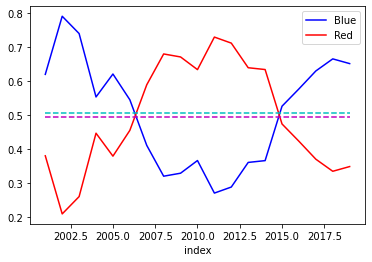

In [342]:
#pool_data = pd.read_csv('dane_years/pools_edited.csv', index_col=0)
pool_data_middle = pd.read_csv('dane_years/pools_data/no_votes.csv', index_col=0).iloc[:,:-1]
pool_data_middle = pool_data_middle.divide(pool_data_middle.sum(1),0)
pool_data_middle.plot(color=['b','r'])
means = pool_data_middle.mean(0)
plt.plot([2001,2019],[means[0],means[0]],'c--')
plt.plot([2001,2019],[means[1],means[1]],'m--')
plt.show()

## Voting data

In [343]:
path = 'wyniki_wyborow/Simple/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()
files

['2001_WS.csv',
 '2005_WS.csv',
 '2007_WS.csv',
 '2011_WS.csv',
 '2015_WS.csv',
 '2019_WS.csv']

In [344]:
vote_list = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files[:]]
vote_list[0] = vote_list[0].iloc[1:,:]

In [345]:
vote_list[0]['jednostka'] = [j.upper() for j in vote_list[0]['jednostka']]
vote_list[0] = vote_list[0].sort_values(['jednostka'])
vote_list[0].columns = ['województwo'] + vote_list[0].columns.values.tolist()[1:] 

In [346]:
vote_list[0] = vote_list[0].set_index('województwo')

## Neighbours

In [347]:
with open('wojew_neighbours.pkl', 'rb') as f:
    neighbours = pickle.load(f)

## Stat data

In [348]:
path = 'dane_years/'
files = list(filter(lambda x: os.path.isfile(path+x), os.listdir(path)))
files.sort()

In [349]:
stat_list_org = [(lambda x: pd.read_csv(path+x,index_col=0, header=0))(f) for f in files]

In [350]:
for s in stat_list_org:
    s['wyksztalcenie_wyzsze'] = s['wyksztalcenie_wyzsze'].fillna(0)

In [351]:
stat_list_org[0].isna().sum(0)

emeryci_i_rencisci                   0
bezrobocie_zarejsestrowane           0
bezrobocie_zarejsestrowane_gminy    16
malzenstwa_zawarte                   0
ludnosc_na_1km2                     16
dochody_gminy                        0
dochody_na_mieszkanca               16
wyksztalcenie_wyzsze                 0
wyksztalcenie_gim_pod_nizsze         0
wyksztalcenie_srednie                0
rozwody_powiat                       0
udzial_wiek_przedprodukcyjny        16
udzial_wiek_produkcyjny             16
udzial_wiek_poprodukcyjny           16
praca_najemna                        0
praca_wlasny_rachunek                0
socjal_500plus                      16
socjal                               0
dochody_brutto_na_mieszkanca         0
PKB_na_1_mieszkanca                  0
przestepstwa_ogolem                 16
dtype: int64

In [352]:
stat_list_org[0].columns[stat_list_org[0].isna().sum(0) > 0]

Index(['bezrobocie_zarejsestrowane_gminy', 'ludnosc_na_1km2',
       'dochody_na_mieszkanca', 'udzial_wiek_przedprodukcyjny',
       'udzial_wiek_produkcyjny', 'udzial_wiek_poprodukcyjny',
       'socjal_500plus', 'przestepstwa_ogolem'],
      dtype='object')

In [353]:
data = [['mazowieckie',35558], 
['wielkopolskie',29826], 
['lubelskie',25122], 
['warmińsko-mazurskie',24173], 
['zachodniopomorskie',22892], 
['podlaskie',20187], 
['dolnośląskie',19947], 
['pomorskie',18310], 
['łódzkie',18219], 
['kujawsko-pomorskie',17972], 
['podkarpackie',17846], 
['małopolskie',15183], 
['lubuskie',13988], 
['śląskie',12333], 
['świętokrzyskie',11711], 
['opolskie',9412]]

woj_pow = pd.DataFrame(data, columns=['jednostka','powierzchnnia_km2'])

In [354]:
woj_pow['jednostka'] = woj_pow['jednostka'] .str.upper() 

In [355]:
for s in range(len(stat_list_org)):
    stat_list_org[s] = pd.merge(stat_list_org[s], woj_pow, left_index=True, right_on='jednostka')
    stat_list_org[s] = stat_list_org[s].set_index('jednostka')

## Use 2 approaches to estimate date from years without elections

In [356]:
#party_in_region(df_vote, df_poll)
par_in_reg_list = [vote_list[0].iloc[:,:-1]]
#region_in_party(df_vote, df_poll)
reg_in_par_list = [vote_list[0].iloc[:,:-1]]
for pool in pool_data_middle[1:].iterrows():
    if int(pool[0]) < 2005: df_vote = vote_list[0]
    elif int(pool[0]) < 2007: df_vote = vote_list[1]
    elif int(pool[0]) < 2011: df_vote = vote_list[2]
    elif int(pool[0]) < 2015: df_vote = vote_list[3]
    elif int(pool[0]) < 2019: df_vote = vote_list[4]
    else: df_vote = vote_list[5]
    
    par_in_reg_list.append(party_in_region(df_vote.iloc[:,:-1], pool[1]))
    reg_in_par_list.append(region_in_party(df_vote.iloc[:,:-1], pool[1]))

In [357]:
for vl, i in zip(vote_list.copy(),[0,4,6,10,14,18]):    
    par_in_reg_list[i] = vl.iloc[:,:-1].div(vl.iloc[:,:-1].sum(1),0) #vl.iloc[:,:-1]
    reg_in_par_list[i] = vl.iloc[:,:-1].div(vl.iloc[:,:-1].sum(1),0) #vl.iloc[:,:-1]

In [358]:
pool_d = par_in_reg_list if (False) else reg_in_par_list 

In [359]:
pool_d_plot = []
voter_percent = voter_w.iloc[:,1].values
for p in pool_d:
    pool_d_plot.append(np.average(np.average(p['Blue'].values,weights = voter_percent)))

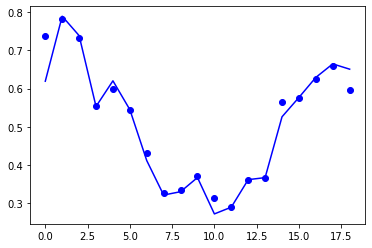

In [360]:
plt.plot(pool_d_plot,'bo')
plt.plot(pool_data_middle['Blue'].values ,'b-')
plt.show()

## Approximating ludnosc_na_1km2

In [361]:
pool_stat_org = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_org, pool_d[1:])]
pool_stat_df_org = pd.concat(pool_stat_org).reset_index(drop=True)

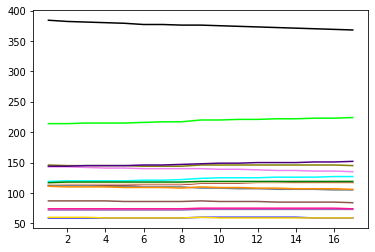

In [362]:
data_reshaped = pool_stat_df_org['ludnosc_na_1km2'].values.reshape(18,-1)
for x in range(data_reshaped.shape[1]):
    plt.plot(data_reshaped[:,x], c=colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1])
plt.savefig('dane_pdf/dane_stat/ludnosc_na_1km2_all.pdf',  bbox_inches='tight')

In [363]:
def lq_lin(x, a, b):
    return x*a + b 

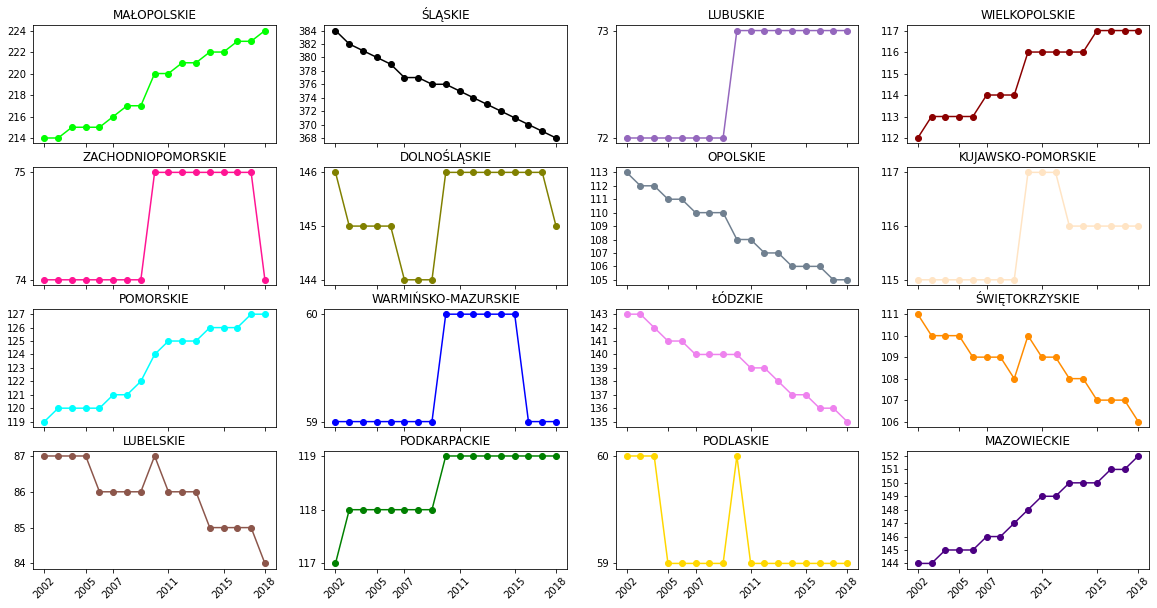

In [364]:
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker

x = np.arange(17)

fig = plt.figure(1, figsize=(20,10))
 
for w in range(data_reshaped.shape[1]):
    (a,b), pcov = curve_fit(lq_lin, x, data_reshaped[1:,w], p0=[1,1])
    xmodel = np.arange(18)
    ymodel = lq_lin(xmodel, a, b)
    
    ax1 = fig.add_subplot(4,4,w+1)
    for axis in [ax1.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
        
    ax1.set_title(stat_list_org[0].index[w])
    ax1.plot(x, data_reshaped[1:,w], marker="o", label="Experiment", 
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    #ax1.plot(xmodel,ymodel, "r--", label="Model")
    ax1.set_xticks([0,3,5,9,13,16])
    #
    if w > 11:
        ax1.set_xticklabels(['2002','2005','2007','2011','2015','2018'],  rotation=45) 
    else:
        ax1.set_xticklabels([]) 
        #plt.xticks([str(i) for i in range(2002,2018)], rotation=45)
    #ax.set_xticklabels(xlabels, rotation=40, ha=ha[n])
    #stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymodel[-1]
plt.savefig('dane_pdf/dane_stat/ludnosc_na_1km2.pdf',  bbox_inches='tight')

Setup value as last year

In [365]:
for w in range(data_reshaped.shape[1]):
    stat_list_org[0]['ludnosc_na_1km2'][w] = data_reshaped[1,w]

## Creating new stat data

In [366]:
stat_list_org[1].columns[stat_list_org[1].max(0) > 100]

Index(['emeryci_i_rencisci', 'bezrobocie_zarejsestrowane',
       'malzenstwa_zawarte', 'ludnosc_na_1km2', 'dochody_gminy',
       'dochody_na_mieszkanca', 'rozwody_powiat', 'praca_najemna', 'socjal',
       'dochody_brutto_na_mieszkanca', 'PKB_na_1_mieszkanca',
       'przestepstwa_ogolem', 'powierzchnnia_km2'],
      dtype='object')

In [367]:
for s in stat_list_org:
    s['ludnosc'] = s['ludnosc_na_1km2']*s['powierzchnnia_km2']
    s['emeryci_i_rencisci_ludnosc'] = s['emeryci_i_rencisci']/s['ludnosc']
    s['bezrobocie_zarejsestrowane_ludnosc'] = s['bezrobocie_zarejsestrowane']/s['ludnosc']
    s['malzenstwa_zawarte_ludnosc'] = s['malzenstwa_zawarte']/s['ludnosc']
    s['dochody_gminy_ludnosc'] = s['dochody_gminy']/s['ludnosc']
    s['rozwody_powiat_ludnosc'] = s['rozwody_powiat']/s['ludnosc']
    s['przestepstwa_ludnosc'] = s['przestepstwa_ogolem']/s['ludnosc']
    s['rozwody_malzenstwa'] = s['rozwody_powiat']/s['malzenstwa_zawarte']

### Correlation
Corr between real data before scaling and outpots for each party based on rescaled output with poll and real data

In [368]:
pool_stat_org = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_org, pool_d[1:])]
pool_stat_df_org = pd.concat(pool_stat_org).reset_index(drop=True)

pool_stat_df_org['random'] = np.random.randn(pool_stat_df_org.shape[0])

cols = pool_stat_df_org.columns.tolist()
cols = cols[:-3] + ['random'] + cols[-3:-1]

pool_stat_df_org = pool_stat_df_org[cols]

In [369]:
rand_corr = []
for i in range(1000):
    pool_stat_df_org['random'] = np.random.randn(pool_stat_df_org.shape[0])
    rd_corr = pool_stat_df_org.corr().iloc[-1:,-3].values[0]
    rand_corr.append(np.abs(rd_corr))

0.08528829684662598
0.091


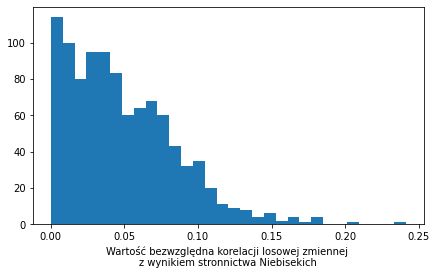

In [370]:
#plt.axhline(np.mean(rand_corr)+np.std(rand_corr))
print(np.mean(rand_corr)+np.std(rand_corr))
#sn.displot(rand_corr,bins=20)
plt.figure(figsize=(7,4))
plt.hist(rand_corr,bins=30)
print((np.array(rand_corr)>0.1).sum()/1000)
#plt.ylabel('Liczba wystapień wartości w dnaym przedziale')
plt.xlabel(f'Wartość bezwzględna korelacji losowej zmiennej \nz wynikiem stronnictwa Niebisekich')
plt.savefig('dane_pdf/dane_stat/random_vvariable_hist.pdf',  bbox_inches='tight')

### Compare Old and New variables

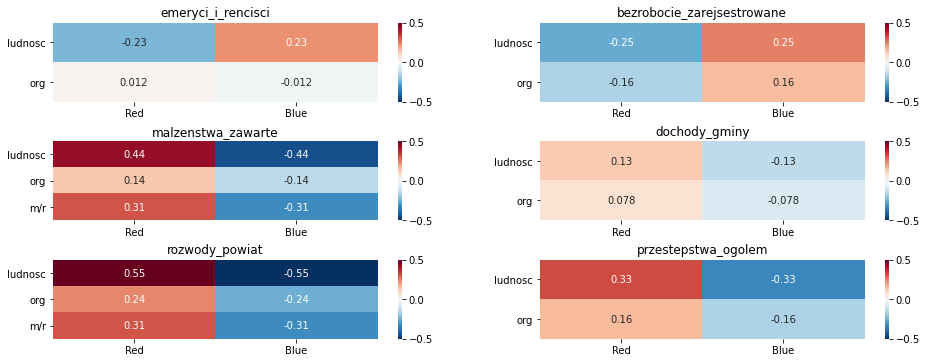

In [371]:
fig = plt.figure(1, figsize=(16,8)) 
plt.subplots_adjust(hspace=0.5)
for w, c in enumerate([
    'emeryci_i_rencisci',
    'bezrobocie_zarejsestrowane',
    'malzenstwa_zawarte',
    'dochody_gminy',
    'rozwody_powiat',
    'przestepstwa_ogolem']):
    #fig, ax = plt.subplots(figsize=(5,2))
    ax = fig.add_subplot(4,2,w+1)
    ax.set_title(c)
    if(c in ['malzenstwa_zawarte', 'rozwody_powiat']):
        tmp = pool_stat_df_org.corr().loc[[c+'_ludnosc',c,'rozwody_malzenstwa'],['Red','Blue']].copy()
        tmp.index = ['ludnosc','org','m/r']
        g = sn.heatmap(tmp,annot=True, cmap='RdBu_r', ax=ax, vmin=-1/2, vmax=1/2)
    elif c == 'przestepstwa_ogolem':
        tmp = pool_stat_df_org.corr().loc[['przestepstwa_ludnosc',c],['Red','Blue']].copy()
        tmp.index = ['ludnosc','org']
        g = sn.heatmap(tmp,annot=True, cmap='RdBu_r', ax=ax, vmin=-1/2, vmax=1/2)
    else:
        tmp = pool_stat_df_org.corr().loc[[c+'_ludnosc',c],['Red','Blue']].copy()
        tmp.index = ['ludnosc','org']
        g = sn.heatmap(tmp,annot=True, cmap='RdBu_r', ax=ax, vmin=-1/2, vmax=1/2)
    g.set_yticklabels(g.get_yticklabels(), rotation = 0)

plt.savefig('dane_pdf/dane_stat/corrs_new_old.pdf',  bbox_inches='tight')

In [372]:
(pool_stat_df_org
                       .corr()
                       .iloc[-2:,:-2][pool_stat_df_org
                                      .corr()
                                      .iloc[-2:,:-2]
                                      .abs() > 0.1])

,emeryci_i_rencisci,bezrobocie_zarejsestrowane,bezrobocie_zarejsestrowane_gminy,malzenstwa_zawarte,ludnosc_na_1km2,dochody_gminy,dochody_na_mieszkanca,wyksztalcenie_wyzsze,wyksztalcenie_gim_pod_nizsze,wyksztalcenie_srednie,...,powierzchnnia_km2,ludnosc,emeryci_i_rencisci_ludnosc,bezrobocie_zarejsestrowane_ludnosc,malzenstwa_zawarte_ludnosc,dochody_gminy_ludnosc,rozwody_powiat_ludnosc,przestepstwa_ludnosc,rozwody_malzenstwa,random
Blue,NaN,0.155267,NaN,-0.135066,NaN,NaN,NaN,0.13546,0.205325,-0.247968,...,NaN,NaN,0.228949,0.25258,-0.438434,-0.12987,-0.550899,-0.328121,-0.313341,NaN
Red,NaN,-0.155267,NaN,0.135066,NaN,NaN,NaN,-0.13546,-0.205325,0.247968,...,NaN,NaN,-0.228949,-0.25258,0.438434,0.12987,0.550899,0.328121,0.313341,NaN


### Delete old variables

In [373]:
for w, c in enumerate([
    'emeryci_i_rencisci',
    'bezrobocie_zarejsestrowane',
    'malzenstwa_zawarte',
    'dochody_gminy',
    'rozwody_powiat',
    'przestepstwa_ogolem']):
    pool_stat_df_org = pool_stat_df_org.drop(c, axis=1)

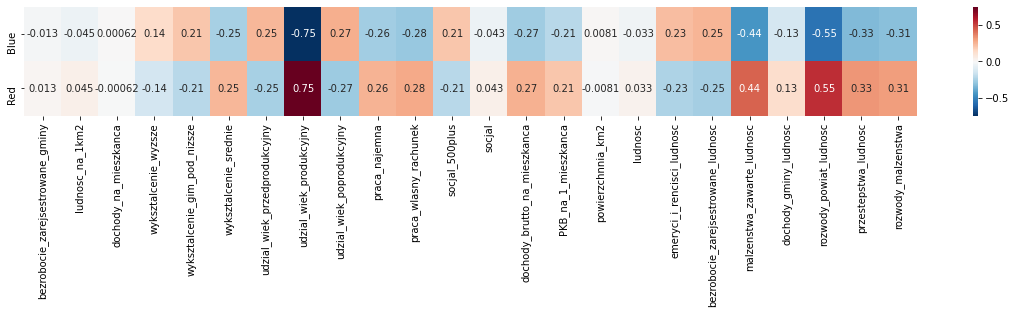

In [374]:
fig, ax = plt.subplots(figsize=(20,2))
sn.heatmap(pool_stat_df_org.corr().iloc[-2:,:-3], annot=True, cmap='RdBu_r', ax=ax)

plt.savefig('dane_pdf/dane_stat/all_correlations.pdf',  bbox_inches='tight')

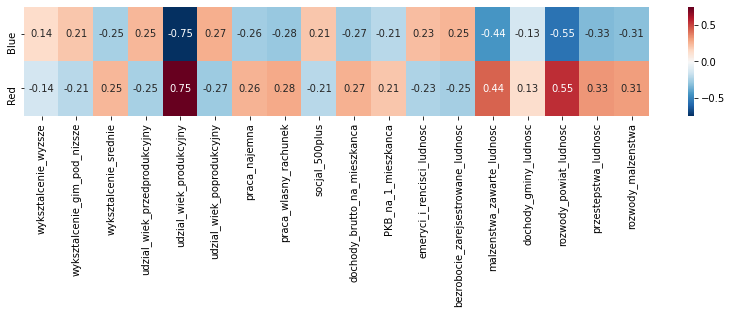

In [375]:
fig, ax = plt.subplots(figsize=(14,2))
pool_names_highcorr = (pool_stat_df_org
                       .corr()
                       .iloc[-2:,:-2][pool_stat_df_org
                                      .corr()
                                      .iloc[-2:,:-2]
                                      .abs() > 0.1]
                       .dropna(1))
sn.heatmap(pool_names_highcorr.dropna(1), annot=True, cmap='RdBu_r', ax=ax)
plt.savefig('dane_pdf/dane_stat/all_correlations_choosed.pdf',  bbox_inches='tight')

In [376]:
pool_names_highcorr

,wyksztalcenie_wyzsze,wyksztalcenie_gim_pod_nizsze,wyksztalcenie_srednie,udzial_wiek_przedprodukcyjny,udzial_wiek_produkcyjny,udzial_wiek_poprodukcyjny,praca_najemna,praca_wlasny_rachunek,socjal_500plus,dochody_brutto_na_mieszkanca,PKB_na_1_mieszkanca,emeryci_i_rencisci_ludnosc,bezrobocie_zarejsestrowane_ludnosc,malzenstwa_zawarte_ludnosc,dochody_gminy_ludnosc,rozwody_powiat_ludnosc,przestepstwa_ludnosc,rozwody_malzenstwa
Blue,0.13546,0.205325,-0.247968,0.24773,-0.747516,0.270503,-0.261207,-0.280812,0.20763,-0.26749,-0.210211,0.228949,0.25258,-0.438434,-0.12987,-0.550899,-0.328121,-0.313341
Red,-0.13546,-0.205325,0.247968,-0.24773,0.747516,-0.270503,0.261207,0.280812,-0.20763,0.26749,0.210211,-0.228949,-0.25258,0.438434,0.12987,0.550899,0.328121,0.313341


In [377]:
col_highcorr = pool_names_highcorr.columns.values.tolist()

In [378]:
for ch in col_highcorr:
    print('\item',ch )

\item wyksztalcenie_wyzsze
\item wyksztalcenie_gim_pod_nizsze
\item wyksztalcenie_srednie
\item udzial_wiek_przedprodukcyjny
\item udzial_wiek_produkcyjny
\item udzial_wiek_poprodukcyjny
\item praca_najemna
\item praca_wlasny_rachunek
\item socjal_500plus
\item dochody_brutto_na_mieszkanca
\item PKB_na_1_mieszkanca
\item emeryci_i_rencisci_ludnosc
\item bezrobocie_zarejsestrowane_ludnosc
\item malzenstwa_zawarte_ludnosc
\item dochody_gminy_ludnosc
\item rozwody_powiat_ludnosc
\item przestepstwa_ludnosc
\item rozwody_malzenstwa


In [379]:
col_not_na0 = stat_list_org[0].columns[stat_list_org[0].isna().sum(0) == 0]
col_not_na17 = stat_list_org[0].columns[stat_list_org[17].isna().sum(0) == 0]

In [380]:
df1_null = stat_list_org[0].count()
col_df1_null = df1_null[df1_null==0].index.values.tolist()

In [381]:
col_df1_null

['bezrobocie_zarejsestrowane_gminy',
 'dochody_na_mieszkanca',
 'udzial_wiek_przedprodukcyjny',
 'udzial_wiek_produkcyjny',
 'udzial_wiek_poprodukcyjny',
 'socjal_500plus',
 'przestepstwa_ogolem',
 'przestepstwa_ludnosc']

In [382]:
cols_to_fill = list(set(col_df1_null).intersection(col_highcorr))
cols_to_fill = cols_to_fill
cols_to_fill

['udzial_wiek_poprodukcyjny',
 'przestepstwa_ludnosc',
 'socjal_500plus',
 'udzial_wiek_przedprodukcyjny',
 'udzial_wiek_produkcyjny']

In [383]:
dflast_null = stat_list_org[-1].count()
col_dflast_null = dflast_null[dflast_null==0].index.values.tolist()
cols_to_fill_last = list(set(col_dflast_null).intersection(col_highcorr))
cols_to_fill_last

['dochody_brutto_na_mieszkanca']

Selecting columns:
- udzial_wiek_produkcyjny 
- udzial_wiek_przedprodukcyjny
- udzial_wiek_poprodukcyjny
- przestepstwa_ogolem
- dochody_brutto_na_mieszkanca (for last)

In [384]:
df_sel_null_col = pd.DataFrame(columns=cols_to_fill+cols_to_fill_last+['ludnosc_na_1km2'])
for s in stat_list_org:
    cols_list = df_sel_null_col.columns.values.tolist()
    df_sel_null_col = df_sel_null_col.append(s[cols_list])

### udzial_wiek_produkcyjny

In [385]:
def lq(x, a, b, c):
    return x*x*a + x*b + c

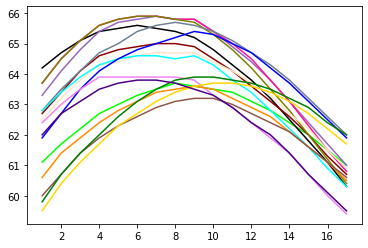

In [386]:
data_reshaped = df_sel_null_col['udzial_wiek_produkcyjny'].values.reshape(18,-1)
for x in range(data_reshaped.shape[1]):
    plt.plot(data_reshaped[:,x], c=colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1])
plt.savefig('dane_pdf/dane_stat/udzial_wiek_produkcyjny_all.pdf',  bbox_inches='tight')

In [387]:
data_reshaped.shape

(18, 16)

MAŁOPOLSKIE           RMSE 0.0038150306562253766
ŚLĄSKIE               RMSE 0.010225520548776748
LUBUSKIE              RMSE 0.032914769623019605
WIELKOPOLSKIE         RMSE 0.029697383597401848
ZACHODNIOPOMORSKIE    RMSE 0.017715959448794717
DOLNOŚLĄSKIE          RMSE 0.022857706550112062
OPOLSKIE              RMSE 0.012787895343895975
KUJAWSKO-POMORSKIE    RMSE 0.011256905238875656
POMORSKIE             RMSE 0.01374127359922268
WARMIŃSKO-MAZURSKIE   RMSE 0.00923298731257192
ŁÓDZKIE               RMSE 0.01986037758756752
ŚWIĘTOKRZYSKIE        RMSE 0.0059309172585441305
LUBELSKIE             RMSE 0.004243003703029074
PODKARPACKIE          RMSE 0.005847447338068247
PODLASKIE             RMSE 0.0008501790809202414
MAZOWIECKIE           RMSE 0.014280033995022024


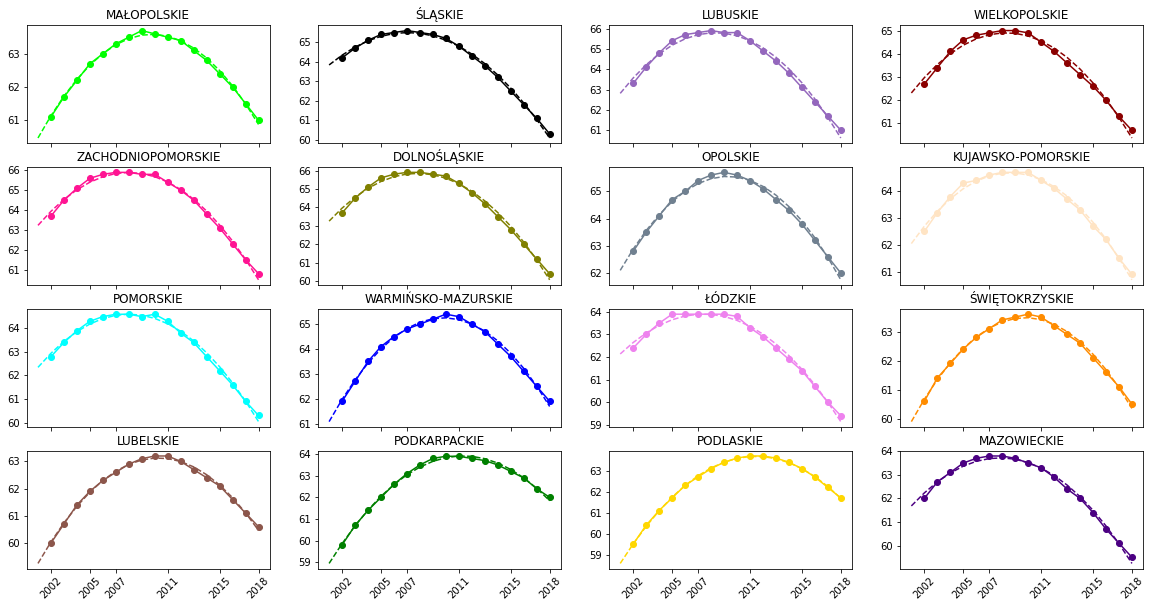

In [388]:
fig = plt.figure(1, figsize=(20,10)) 
x = np.arange(17)
for w in range(data_reshaped.shape[1]):
    (a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,w], p0=[0.05,0.05,0.05])
    xmodel = np.arange(-1,17)
    ymodel = lq(xmodel, a, b, c)
    perr = np.sqrt(np.diag(pcov))

    print(df_sel_null_col.index[w].ljust(20)," RMSE",np.sum((data_reshaped[1:,w]-ymodel[1:])**2)/ymodel[1:].shape[0])
    stat_list_org[0]['udzial_wiek_produkcyjny'][w] = ymodel[0]
    ax1 = fig.add_subplot(4,4,w+1)
    
    for axis in [ax1.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
        
    ax1.set_title(stat_list_org[0].index[w])
    ax1.plot(x, data_reshaped[1:,w], marker="o", label="Experiment", 
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.plot(xmodel,ymodel, linestyle="--", label="Model",
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.set_xticks([0,3,5,9,13,16])
    #
    if w > 11:
        ax1.set_xticklabels(['2002','2005','2007','2011','2015','2018'],  rotation=45) 
    else:
        ax1.set_xticklabels([]) 
        
    stat_list_org[0]['udzial_wiek_produkcyjny'][w] = ymodel[0]
plt.savefig('dane_pdf/dane_stat/udzial_wiek_produkcyjny.pdf',  bbox_inches='tight')

### udzial_wiek_przedprodukcyjny

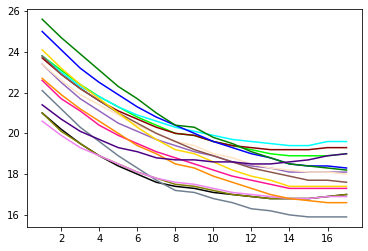

In [389]:
data_reshaped = df_sel_null_col['udzial_wiek_przedprodukcyjny'].values.reshape(18,-1)
for x in range(data_reshaped.shape[1]):
    plt.plot(data_reshaped[:,x], c=colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1])
plt.savefig('dane_pdf/dane_stat/udzial_wiek_przedprodukcyjny_all.pdf',  bbox_inches='tight')

MAŁOPOLSKIE           RMSE 0.004825775511442974
ŚLĄSKIE               RMSE 0.01353487525040982
LUBUSKIE              RMSE 0.011480301098767532
WIELKOPOLSKIE         RMSE 0.0073535482304376365
ZACHODNIOPOMORSKIE    RMSE 0.007275238268682167
DOLNOŚLĄSKIE          RMSE 0.010096825107752026
OPOLSKIE              RMSE 0.015084987555393876
KUJAWSKO-POMORSKIE    RMSE 0.0037977296181630417
POMORSKIE             RMSE 0.00702998846597465
WARMIŃSKO-MAZURSKIE   RMSE 0.0055484732592727785
ŁÓDZKIE               RMSE 0.007325016693984078
ŚWIĘTOKRZYSKIE        RMSE 0.003784070903903387
LUBELSKIE             RMSE 0.0030070418260183503
PODKARPACKIE          RMSE 0.009793298124203317
PODLASKIE             RMSE 0.00494111576519157
MAZOWIECKIE           RMSE 0.013645359072421447


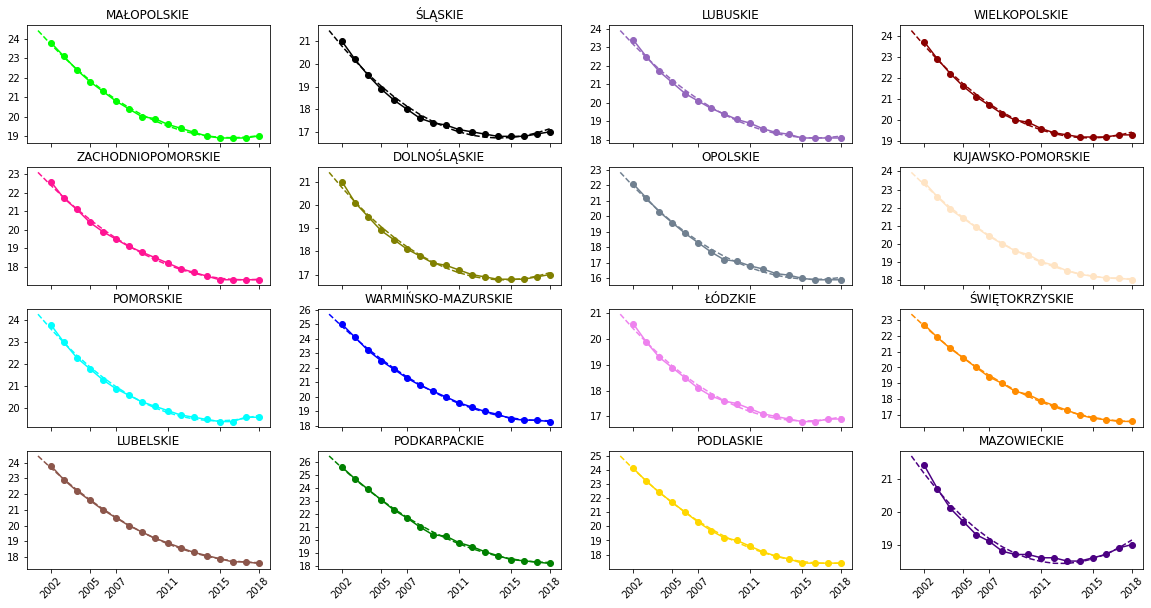

In [390]:
fig = plt.figure(1, figsize=(20,10)) 
x = np.arange(17)
for w in range(data_reshaped.shape[1]):
    (a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,w], p0=[0.05,0.05,0.05])
    xmodel = np.arange(-1,17)
    ymodel = lq(xmodel, a, b, c)
    perr = np.sqrt(np.diag(pcov))

    print(df_sel_null_col.index[w].ljust(20)," RMSE",np.sum((data_reshaped[1:,w]-ymodel[1:])**2)/ymodel[1:].shape[0])
    stat_list_org[0]['udzial_wiek_przedprodukcyjny'][w] = ymodel[0]
    ax1 = fig.add_subplot(4,4,w+1)
    
    for axis in [ax1.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
        
    ax1.set_title(stat_list_org[0].index[w])
    ax1.plot(x, data_reshaped[1:,w], marker="o", label="Experiment", 
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.plot(xmodel,ymodel, linestyle="--", label="Model",
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.set_xticks([0,3,5,9,13,16])
    #
    if w > 11:
        ax1.set_xticklabels(['2002','2005','2007','2011','2015','2018'],  rotation=45) 
    else:
        ax1.set_xticklabels([]) 
        
    stat_list_org[0]['udzial_wiek_przedprodukcyjny'][w] = ymodel[0]
plt.savefig('dane_pdf/dane_stat/udzial_wiek_przedprodukcyjny.pdf',  bbox_inches='tight')

### udzial_wiek_poprodukcyjny

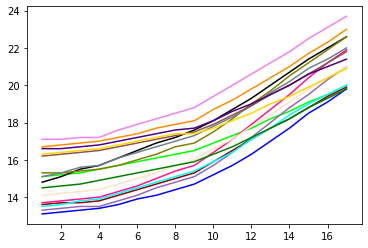

In [391]:
data_reshaped = df_sel_null_col['udzial_wiek_poprodukcyjny'].values.reshape(18,-1)
for x in range(data_reshaped.shape[1]):
    plt.plot(data_reshaped[:,x], c=colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1])
plt.savefig('dane_pdf/dane_stat/udzial_wiek_poprodukcyjny_all.pdf',  bbox_inches='tight')

MAŁOPOLSKIE           RMSE 0.00316396527651308
ŚLĄSKIE               RMSE 0.007505311722211999
LUBUSKIE              RMSE 0.016178898804403423
WIELKOPOLSKIE         RMSE 0.015075881745887513
ZACHODNIOPOMORSKIE    RMSE 0.0130458932799202
DOLNOŚLĄSKIE          RMSE 0.016595641352516143
OPOLSKIE              RMSE 0.00845231591088442
KUJAWSKO-POMORSKIE    RMSE 0.008168518181266456
POMORSKIE             RMSE 0.01249559885873848
WARMIŃSKO-MAZURSKIE   RMSE 0.006106962909082264
ŁÓDZKIE               RMSE 0.010684453347902865
ŚWIĘTOKRZYSKIE        RMSE 0.006365264372081888
LUBELSKIE             RMSE 0.005254659139197894
PODKARPACKIE          RMSE 0.004853092939962439
PODLASKIE             RMSE 0.007789716505800923
MAZOWIECKIE           RMSE 0.007950889334073284


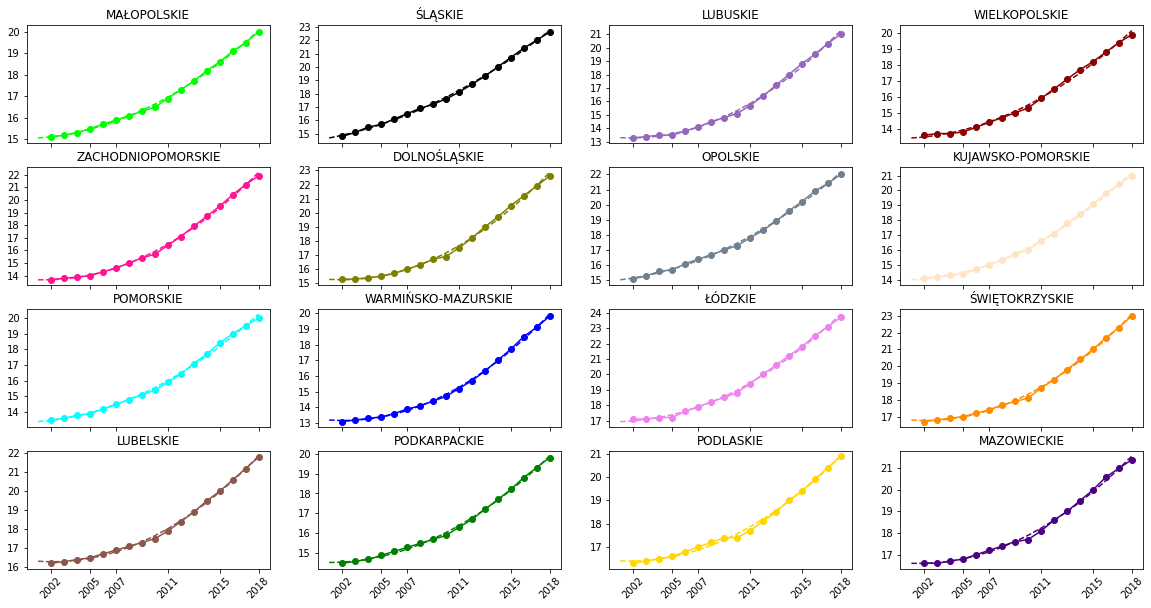

In [392]:
fig = plt.figure(1, figsize=(20,10))

x = np.arange(17)
for w in range(data_reshaped.shape[1]):
    (a,b,c), pcov = curve_fit(lq, x, data_reshaped[1:,w], p0=[0.05,0.05,0.05])
    xmodel = np.arange(-1,17)
    ymodel = lq(xmodel, a, b, c)
    perr = np.sqrt(np.diag(pcov))

    print(df_sel_null_col.index[w].ljust(20)," RMSE",np.sum((data_reshaped[1:,w]-ymodel[1:])**2)/ymodel[1:].shape[0])
    stat_list_org[0]['udzial_wiek_poprodukcyjny'][w] = ymodel[0]
    ax1 = fig.add_subplot(4,4,w+1)
    
    for axis in [ax1.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
        
    ax1.set_title(stat_list_org[0].index[w])
    ax1.plot(x, data_reshaped[1:,w], marker="o", label="Experiment", 
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.plot(xmodel,ymodel, linestyle="--", label="Model",
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.set_xticks([0,3,5,9,13,16])
    #
    if w > 11:
        ax1.set_xticklabels(['2002','2005','2007','2011','2015','2018'],  rotation=45) 
    else:
        ax1.set_xticklabels([]) 
        
    stat_list_org[0]['udzial_wiek_poprodukcyjny'][w] = ymodel[0]
plt.savefig('dane_pdf/dane_stat/udzial_wiek_poprodukcyjny.pdf',  bbox_inches='tight')

### przestepstwa_ogolem

In [393]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import preprocessing

In [394]:
def lq_sin(x, a, b, c, d):
    return np.sin(x/a*np.pi)*b + x*c + d

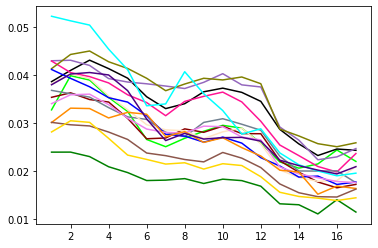

In [395]:
data_reshaped = df_sel_null_col['przestepstwa_ludnosc'].values.reshape(18,-1)
for x in range(data_reshaped.shape[1]):
    plt.plot(data_reshaped[:,x], c=colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1])
plt.savefig('dane_pdf/dane_stat/przestepstwa_ludnosc_all.pdf',  bbox_inches='tight')

#### MINMAX rescaling

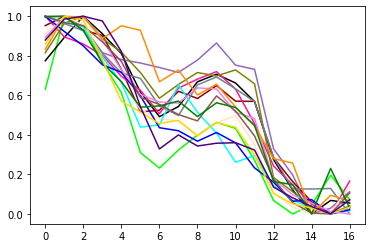

In [396]:
minmax_data_reshaped = preprocessing.minmax_scale(data_reshaped[~np.isnan(data_reshaped)].reshape(17,-1))
for x in range(minmax_data_reshaped.shape[1]):
    plt.plot(minmax_data_reshaped[:,x], c=colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1] )
plt.savefig('dane_pdf/dane_stat/przestepstwa_ludnosc_all.pdf',  bbox_inches='tight')

#### Comparing each year with best line

In [397]:
notnull_data_reshaped = data_reshaped[~np.isnan(data_reshaped)].reshape(17,-1)

In [398]:
mx = notnull_data_reshaped.max(0)
mn = notnull_data_reshaped.min(0)

MAŁOPOLSKIE           RMSE minmax 0.10159950018252682  RMSE 3.760434896534175e-05
ŚLĄSKIE               RMSE minmax 0.10284964205116577  RMSE 4.0500741763200743e-05
LUBUSKIE              RMSE minmax 0.26965514620904707  RMSE 0.0001156695032832995
WIELKOPOLSKIE         RMSE minmax 0.05532254975537902  RMSE 2.160596817793382e-05
ZACHODNIOPOMORSKIE    RMSE minmax 0.10444152567119525  RMSE 5.567933303552253e-05
DOLNOŚLĄSKIE          RMSE minmax 0.19400485932482214  RMSE 7.69586217744842e-05
OPOLSKIE              RMSE minmax 0.08140556446554996  RMSE 3.005830035374502e-05
KUJAWSKO-POMORSKIE    RMSE minmax 0.028122580548659022  RMSE 1.4025168027181782e-05
POMORSKIE             RMSE minmax 0.06255714701293735  RMSE 6.89557247919933e-05
WARMIŃSKO-MAZURSKIE   RMSE minmax 0.02916912460607001  RMSE 1.6688740380454326e-05
ŁÓDZKIE               RMSE minmax 0.052388322760763835  RMSE 1.7714073897048288e-05
ŚWIĘTOKRZYSKIE        RMSE minmax 0.17343759930856817  RMSE 5.559125094388598e-05
LUBELSKIE   

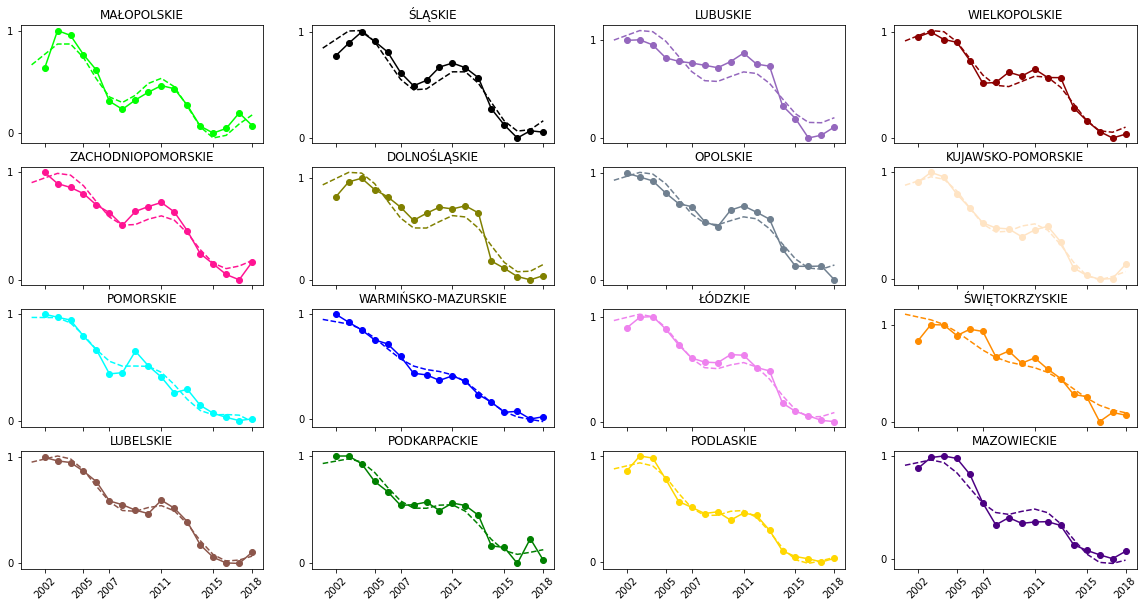

In [399]:
x = np.arange(17)

fig = plt.figure(1, figsize=(20,10))
 
for w in range(data_reshaped.shape[1]):
    (a,b,c,d), pcov = curve_fit(lq_sin, 
                                x, 
                                minmax_data_reshaped[:,w], # data_reshaped[1:,w], 
                                p0=[4,6,-1,1], maxfev = 100000)
    xmodel = np.arange(-1,17)
    ymodel = lq_sin(xmodel, a,b,c,d)
    perr = np.sqrt(np.diag(pcov))
    ax1 = fig.add_subplot(4,4,w+1)
    
    plt.xticks(range(-1,17), rotation=45)
    print(df_sel_null_col.index[w].ljust(20),
          " RMSE minmax",
          np.sum((minmax_data_reshaped[:,w]-ymodel[1:])**2),
          " RMSE",
          np.sum((data_reshaped[1:,w]-(ymodel[1:]*(mx[w]-mn[w])+mn[w]))**2),
         )
    
    for axis in [ax1.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
        
    ax1.set_title(stat_list_org[0].index[w])
    ax1.plot(x, minmax_data_reshaped[:,w], marker="o", label="Experiment", 
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.plot(xmodel,ymodel, linestyle="--", label="Model",
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    
    ax1.set_xticks([0,3,5,9,13,16])
    #
    if w > 11:
        ax1.set_xticklabels(['2002','2005','2007','2011','2015','2018'],  rotation=45) 
    else:
        ax1.set_xticklabels([]) 
    
    #stat_list_org[0]['przestepstwa_ludnosc'][w] = stat_list_org[-1]['przestepstwa_ludnosc'][w] 
    stat_list_org[0]['przestepstwa_ludnosc'][w] = stat_list_org[1]['przestepstwa_ludnosc'][w]
    stat_list_org[0]['przestepstwa_ludnosc'][w] = ymodel[0]
    
plt.savefig('dane_pdf/dane_stat/przestepstwa_ogolem.pdf',  bbox_inches='tight')

### dochody_brutto_na_mieszkanca

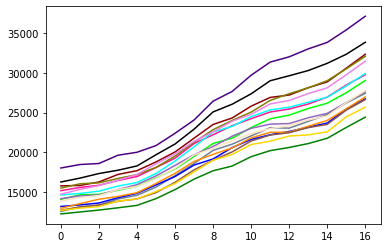

In [400]:
data_reshaped = df_sel_null_col['dochody_brutto_na_mieszkanca'].values.reshape(18,-1)
for x in range(data_reshaped.shape[1]):
    plt.plot(data_reshaped[:,x], c=colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1])
plt.savefig('dane_pdf/dane_stat/dochody_brutto_na_mieszkanca_all.pdf',  bbox_inches='tight')

In [401]:
def lq3(x, a, b, c, d):
    return x*x*x*a + x*x*b + x*c + d

def lq1(x, a, b):
    return x*a + b 

x = np.arange(17)

MAŁOPOLSKIE           MSE 1353130.8878275864  RMSE 1163.2415432005455
ŚLĄSKIE               MSE 1983029.2907284459  RMSE 1408.2007281380186
LUBUSKIE              MSE 1102659.114827824  RMSE 1050.0757662320486
WIELKOPOLSKIE         MSE 1593938.7789102101  RMSE 1262.5128826709888
ZACHODNIOPOMORSKIE    MSE 1234955.1230084854  RMSE 1111.2853472481697
DOLNOŚLĄSKIE          MSE 1721935.4852209485  RMSE 1312.225394214328
OPOLSKIE              MSE 1291217.3776066771  RMSE 1136.317463390701
KUJAWSKO-POMORSKIE    MSE 1051546.4923072509  RMSE 1025.4494099209628
POMORSKIE             MSE 1591253.8691449473  RMSE 1261.4491147664053
WARMIŃSKO-MAZURSKIE   MSE 1060632.5905710773  RMSE 1029.8701814166081
ŁÓDZKIE               MSE 1387655.7189286721  RMSE 1177.9879960885307
ŚWIĘTOKRZYSKIE        MSE 1033690.0239022665  RMSE 1016.70547549537
LUBELSKIE             MSE 1253862.4052856152  RMSE 1119.759976640358
PODKARPACKIE          MSE 924161.7456697712  RMSE 961.3333166336072
PODLASKIE             MSE 10

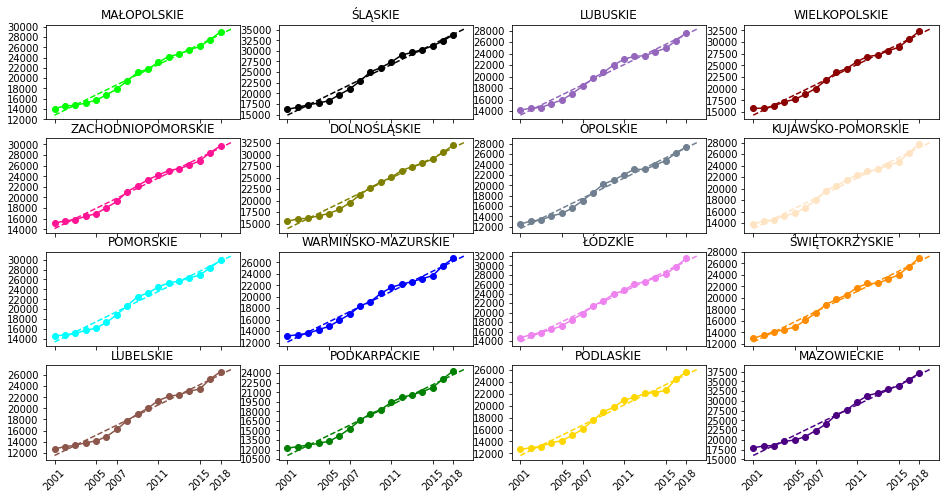

In [402]:
x = np.arange(17)

fig = plt.figure(1, figsize=(16,8))

mse = []
rmse = []

for w in range(data_reshaped.shape[1]):
    (a,b), pcov = curve_fit(lq1, x, data_reshaped[:-1,w], p0=[1,1])
    xmodel = np.arange(18)
    ymodel = lq1(xmodel, a, b)
    perr = np.sqrt(np.diag(pcov))

    mse.append(np.sum((data_reshaped[:-1,w]-ymodel[1:])**2)/ymodel[:-1].shape[0])
    rmse.append(np.sqrt(np.sum((data_reshaped[:-1,w]-ymodel[1:])**2)/ymodel[:-1].shape[0]))
    
    print(df_sel_null_col.index[w].ljust(20),
          " MSE",np.sum((data_reshaped[:-1,w]-ymodel[1:])**2)/ymodel[:-1].shape[0],
          " RMSE",np.sqrt(np.sum((data_reshaped[:-1,w]-ymodel[1:])**2)/ymodel[:-1].shape[0]))
    ax1 = fig.add_subplot(4,4,w+1)
    
    for axis in [ax1.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
        
    ax1.set_title(stat_list_org[0].index[w])
    ax1.plot(x, data_reshaped[:-1,w], marker="o", label="Experiment", 
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.plot(xmodel,ymodel, linestyle="--", label="Model",
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.set_xticks([0,4,6,10,14,16])
    #
    if w > 11:
        ax1.set_xticklabels(['2001','2005','2007','2011','2015','2018'],  rotation=45) 
    else:
        ax1.set_xticklabels([]) 
    stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymodel[-1]
plt.savefig('dane_pdf/dane_stat/dochody_brutto_na_mieszkanca_straight.pdf',  bbox_inches='tight')

print("Avg MSE:", np.mean(mse), "+-", np.std(mse), 
      "Avg RMSE:", np.mean(rmse), "+-", np.std(rmse),)

MAŁOPOLSKIE           MSE 1001566.2174107108  RMSE 1000.7828023156227
ŚLĄSKIE               MSE 1380131.3024248013  RMSE 1174.789897141102
LUBUSKIE              MSE 901479.4779143524  RMSE 949.4627311876715
WIELKOPOLSKIE         MSE 1274430.1843914797  RMSE 1128.9066322736703
ZACHODNIOPOMORSKIE    MSE 1010010.6990843877  RMSE 1004.9928850914258
DOLNOŚLĄSKIE          MSE 1210706.095420665  RMSE 1100.3209056546482
OPOLSKIE              MSE 1055740.3209630873  RMSE 1027.4922486146002
KUJAWSKO-POMORSKIE    MSE 939531.6255735898  RMSE 969.2943957196852
POMORSKIE             MSE 1212321.9707982892  RMSE 1101.0549354134375
WARMIŃSKO-MAZURSKIE   MSE 882571.2444670415  RMSE 939.4526302411641
ŁÓDZKIE               MSE 1200029.3466260068  RMSE 1095.4585097693143
ŚWIĘTOKRZYSKIE        MSE 927161.7310035249  RMSE 962.8923776848194
LUBELSKIE             MSE 953127.8858876805  RMSE 976.2826874874308
PODKARPACKIE          MSE 710405.9622500475  RMSE 842.8558371691137
PODLASKIE             MSE 876238.2

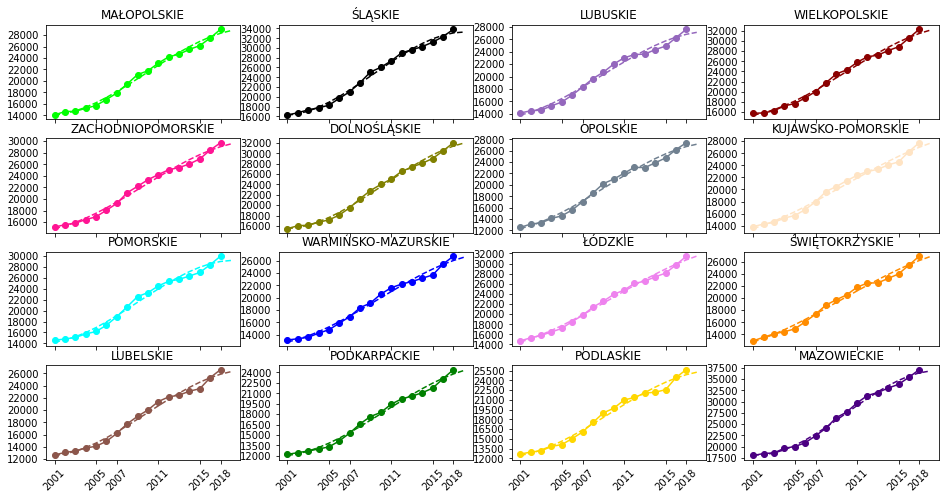

In [403]:
x = np.arange(17)

fig = plt.figure(1, figsize=(16,8))

mse = []
rmse = []
for w in range(data_reshaped.shape[1]):
    (a,b,c,d), pcov = curve_fit(lq3, x, data_reshaped[:-1,w], p0=[1,1,1,1])
    xmodel = np.arange(18)
    ymodel = lq3(xmodel, a, b, c,d)
    perr = np.sqrt(np.diag(pcov))
    
    mse.append(np.sum((data_reshaped[:-1,w]-ymodel[1:])**2)/ymodel[:-1].shape[0])
    rmse.append(np.sqrt(np.sum((data_reshaped[:-1,w]-ymodel[1:])**2)/ymodel[:-1].shape[0]))
    
    print(df_sel_null_col.index[w].ljust(20),
          " MSE",np.sum((data_reshaped[:-1,w]-ymodel[1:])**2)/ymodel[:-1].shape[0],
          " RMSE",np.sqrt(np.sum((data_reshaped[:-1,w]-ymodel[1:])**2)/ymodel[:-1].shape[0]))    
    ax1 = fig.add_subplot(4,4,w+1)
    
    for axis in [ax1.yaxis]:
        axis.set_major_locator(ticker.MaxNLocator(integer=True))
        
    ax1.set_title(stat_list_org[0].index[w])
    ax1.plot(x, data_reshaped[:-1,w], marker="o", label="Experiment", 
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.plot(xmodel,ymodel, linestyle="--", label="Model",
             color=colors.loc[colors.wojewodztwo==stat_list_org[0].index[w],:].values[0][1])
    ax1.set_xticks([0,4,6,10,14,16])
    #
    if w > 11:
        ax1.set_xticklabels(['2001','2005','2007','2011','2015','2018'],  rotation=45) 
    else:
        ax1.set_xticklabels([]) 
    stat_list_org[-1]['dochody_brutto_na_mieszkanca'][w] = ymodel[-1]
plt.savefig('dane_pdf/dane_stat/dochody_brutto_na_mieszkanca.pdf',  bbox_inches='tight')
print("Avg MSE:", np.mean(mse), "+-", np.std(mse), 
      "Avg RMSE:", np.mean(rmse), "+-", np.std(rmse),)

## Compare correlations after rescaling

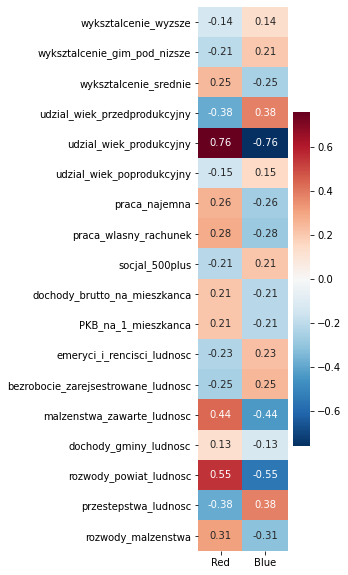

In [404]:
pool_stat_org = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_org, pool_d[1:])]
pool_stat_df_org = pd.concat(pool_stat_org).reset_index(drop=True)

for w, c in enumerate([
    'emeryci_i_rencisci',
    'bezrobocie_zarejsestrowane',
    'malzenstwa_zawarte',
    'dochody_gminy',
    'rozwody_powiat',
    'przestepstwa_ogolem']):
    pool_stat_df_org = pool_stat_df_org.drop(c, axis=1)

fig, ax = plt.subplots(figsize=(2,10))
sn.heatmap(pool_stat_df_org[pool_names_highcorr.columns.values.tolist()+['Red','Blue']].corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

In [405]:
pool_stat_org[0].columns

Index(['index', 'emeryci_i_rencisci', 'bezrobocie_zarejsestrowane',
       'bezrobocie_zarejsestrowane_gminy', 'malzenstwa_zawarte',
       'ludnosc_na_1km2', 'dochody_gminy', 'dochody_na_mieszkanca',
       'wyksztalcenie_wyzsze', 'wyksztalcenie_gim_pod_nizsze',
       'wyksztalcenie_srednie', 'rozwody_powiat',
       'udzial_wiek_przedprodukcyjny', 'udzial_wiek_produkcyjny',
       'udzial_wiek_poprodukcyjny', 'praca_najemna', 'praca_wlasny_rachunek',
       'socjal_500plus', 'socjal', 'dochody_brutto_na_mieszkanca',
       'PKB_na_1_mieszkanca', 'przestepstwa_ogolem', 'powierzchnnia_km2',
       'ludnosc', 'emeryci_i_rencisci_ludnosc',
       'bezrobocie_zarejsestrowane_ludnosc', 'malzenstwa_zawarte_ludnosc',
       'dochody_gminy_ludnosc', 'rozwody_powiat_ludnosc',
       'przestepstwa_ludnosc', 'rozwody_malzenstwa', 'Blue', 'Red'],
      dtype='object')

## Rescale the data

In [406]:
col_not_na0 = stat_list_org[0].columns[stat_list_org[0].isna().sum(0) == 0]
col_not_na17 = stat_list_org[0].columns[stat_list_org[17].isna().sum(0) == 0]

In [407]:
stat_list_minmax = stat_list_org.copy()
stat_list_mean = stat_list_org.copy()

In [408]:
#MINMAX scaling
for st in range(len(stat_list_org)):
    stat_list_minmax[st] = stat_list_org[st][col_not_na0 & col_not_na17].copy()
    # min max normalization
    stat_list_minmax[st] = (stat_list_minmax[st]-stat_list_minmax[st].min(0)) / (stat_list_minmax[st].max(0)-stat_list_minmax[st].min(0))

In [409]:
#NORLAMISATION
for st in range(len(stat_list_org)):
    stat_list_mean[st] = stat_list_org[st][col_not_na0 & col_not_na17].copy()
    # nrmalization mean (around 0)
    stat_list_mean[st] = (stat_list_mean[st]-stat_list_mean[st].mean(0)) / (stat_list_mean[st].std(0))

In [410]:
stat_list = stat_list_mean if (True) else stat_list_minmax

## Examining stat data

In [411]:
high_corr_columns_final = pool_names_highcorr.columns & col_not_na0 & col_not_na17
print(high_corr_columns_final.shape, high_corr_columns_final)

(17,) Index(['wyksztalcenie_wyzsze', 'wyksztalcenie_gim_pod_nizsze',
       'wyksztalcenie_srednie', 'udzial_wiek_przedprodukcyjny',
       'udzial_wiek_produkcyjny', 'udzial_wiek_poprodukcyjny', 'praca_najemna',
       'praca_wlasny_rachunek', 'dochody_brutto_na_mieszkanca',
       'PKB_na_1_mieszkanca', 'emeryci_i_rencisci_ludnosc',
       'bezrobocie_zarejsestrowane_ludnosc', 'malzenstwa_zawarte_ludnosc',
       'dochody_gminy_ludnosc', 'rozwody_powiat_ludnosc',
       'przestepstwa_ludnosc', 'rozwody_malzenstwa'],
      dtype='object')


In [412]:
pool_names_highcorr

,wyksztalcenie_wyzsze,wyksztalcenie_gim_pod_nizsze,wyksztalcenie_srednie,udzial_wiek_przedprodukcyjny,udzial_wiek_produkcyjny,udzial_wiek_poprodukcyjny,praca_najemna,praca_wlasny_rachunek,socjal_500plus,dochody_brutto_na_mieszkanca,PKB_na_1_mieszkanca,emeryci_i_rencisci_ludnosc,bezrobocie_zarejsestrowane_ludnosc,malzenstwa_zawarte_ludnosc,dochody_gminy_ludnosc,rozwody_powiat_ludnosc,przestepstwa_ludnosc,rozwody_malzenstwa
Blue,0.13546,0.205325,-0.247968,0.24773,-0.747516,0.270503,-0.261207,-0.280812,0.20763,-0.26749,-0.210211,0.228949,0.25258,-0.438434,-0.12987,-0.550899,-0.328121,-0.313341
Red,-0.13546,-0.205325,0.247968,-0.24773,0.747516,-0.270503,0.261207,0.280812,-0.20763,0.26749,0.210211,-0.228949,-0.25258,0.438434,0.12987,0.550899,0.328121,0.313341


In [413]:
len(stat_list)

18

In [414]:
len(stat_list_org)

18

In [415]:
len(pool_d[:-1])

18

In [416]:
pool_stat_org = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_org, pool_d[1:])]
pool_stat_m = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_mean, pool_d[1:])]
pool_stat_mm = [pd.merge(s, p, left_index=True, right_index=True).reset_index() for s,p in zip(stat_list_minmax, pool_d[1:])]

In [417]:
pool_stat_df_org =  pd.concat(pool_stat_org).reset_index(drop=True)
pool_stat_df_m = pd.concat(pool_stat_m).reset_index(drop=True)
pool_stat_df_mm = pd.concat(pool_stat_mm).reset_index(drop=True)

In [418]:
try:
    for w, c in enumerate([
        'emeryci_i_rencisci',
        'bezrobocie_zarejsestrowane',
        'malzenstwa_zawarte',
        'dochody_gminy',
        'rozwody_powiat']):
        pool_stat_df_org = pool_stat_df_org.drop(c, axis=1)
        pool_stat_df_m = pool_stat_df_m.drop(c, axis=1)
        pool_stat_df_mm = pool_stat_df_mm.drop(c, axis=1)
except:
    print('already deleted')

pool_stat_df_org = pool_stat_df_org[high_corr_columns_final.values.tolist()+['Red','Blue','index']]
pool_stat_df_m = pool_stat_df_m[high_corr_columns_final.values.tolist()+['Red','Blue','index']]
pool_stat_df_mm = pool_stat_df_mm[high_corr_columns_final.values.tolist()+['Red','Blue','index']]

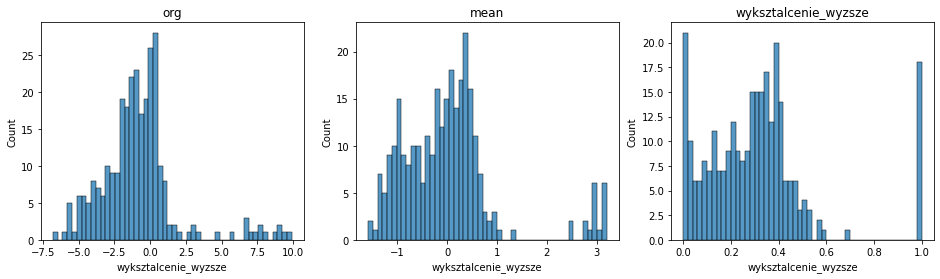

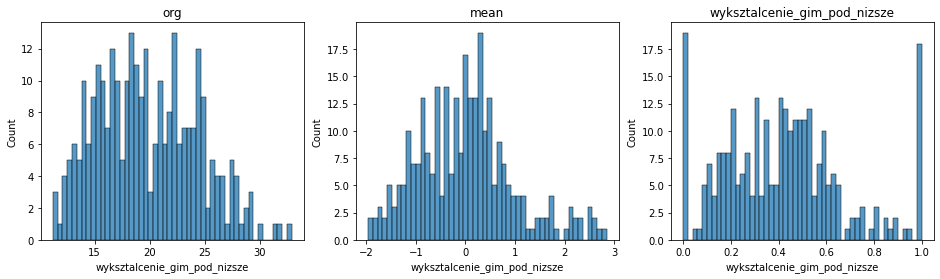

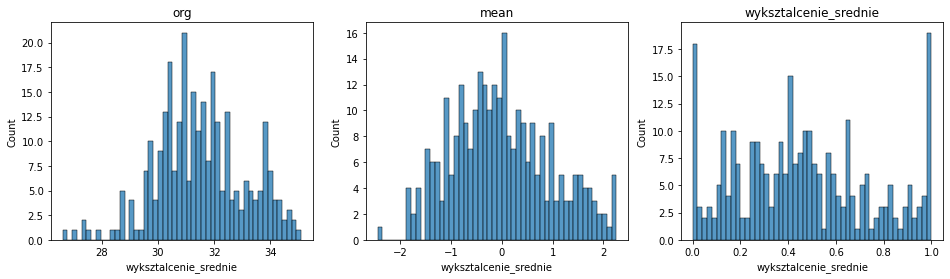

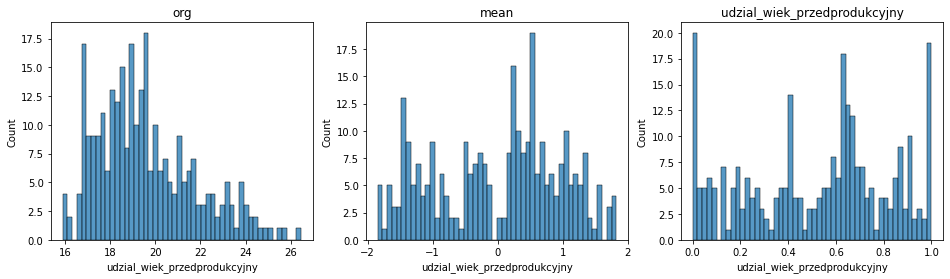

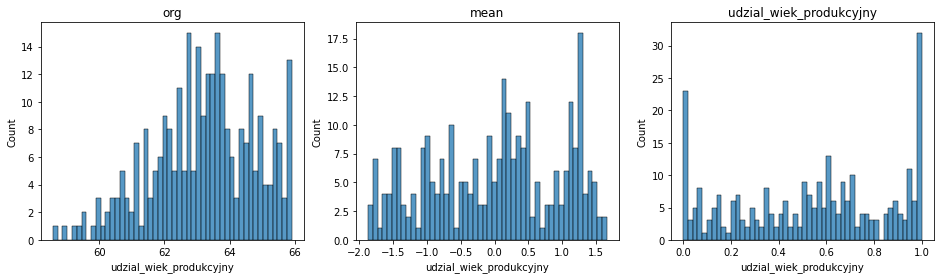

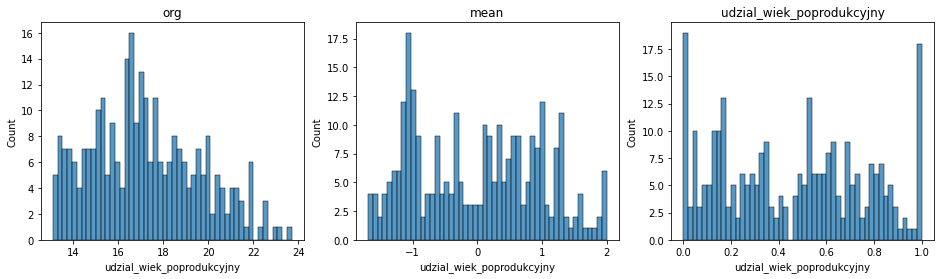

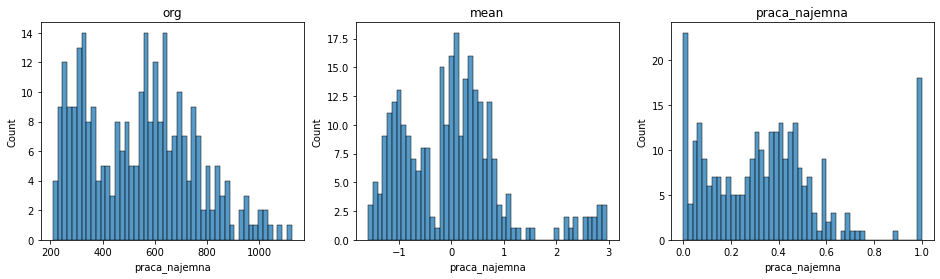

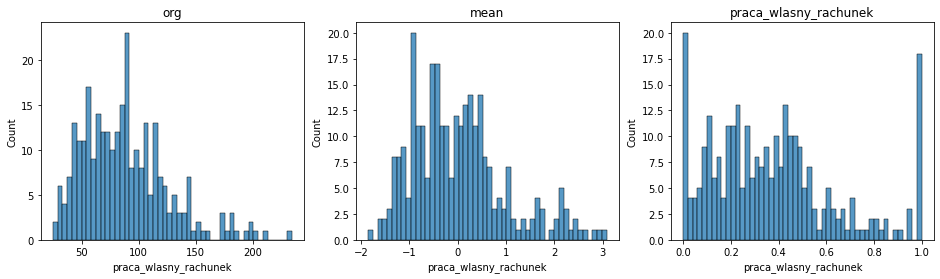

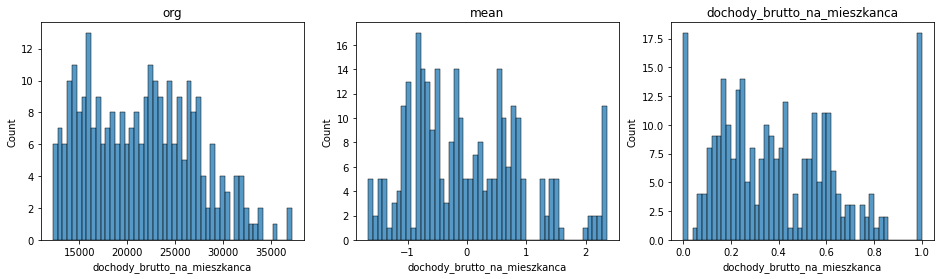

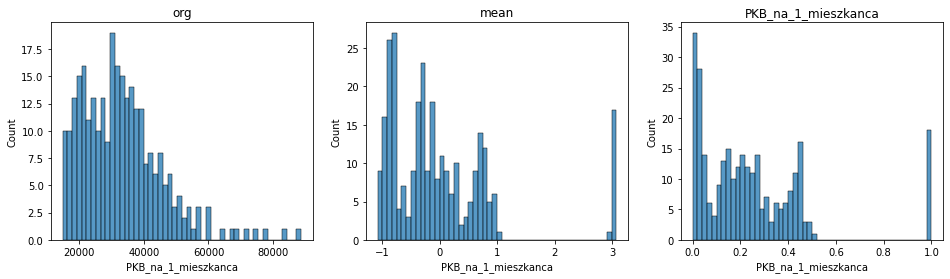

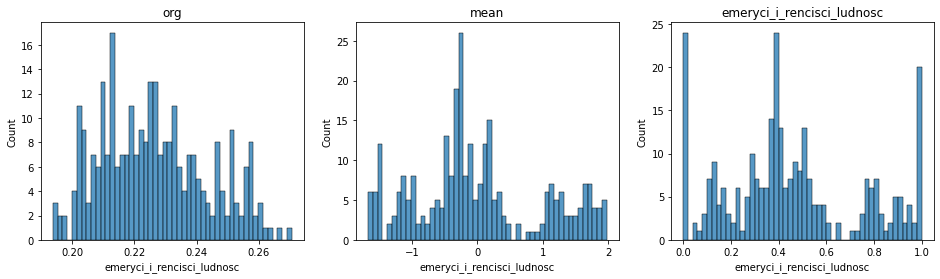

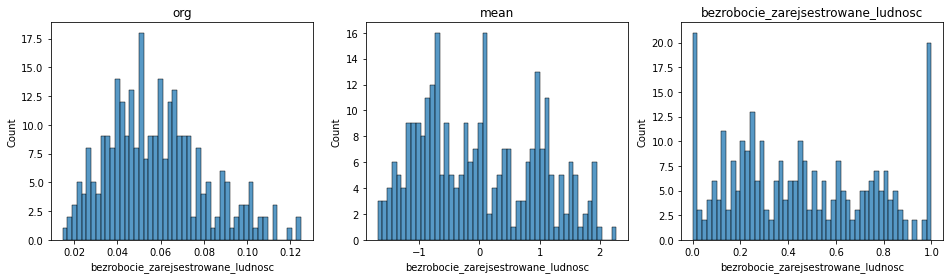

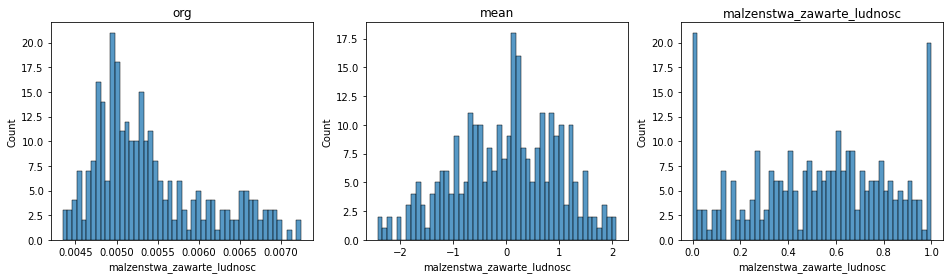

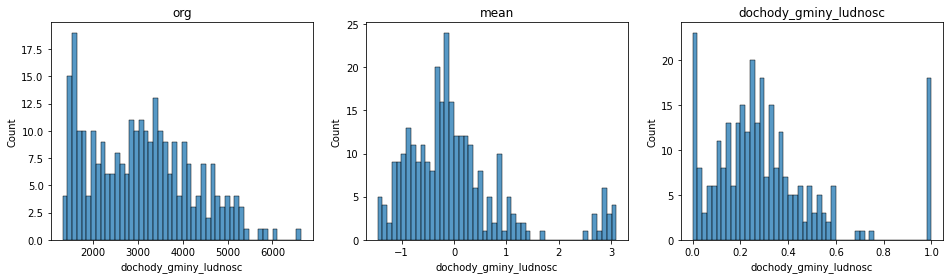

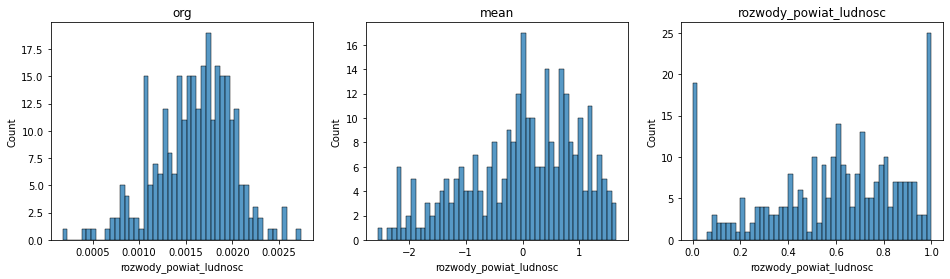

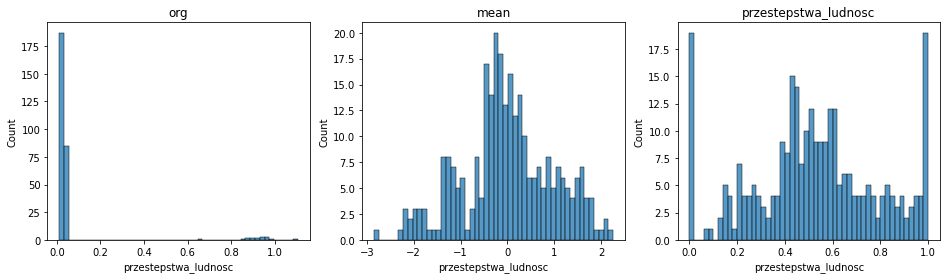

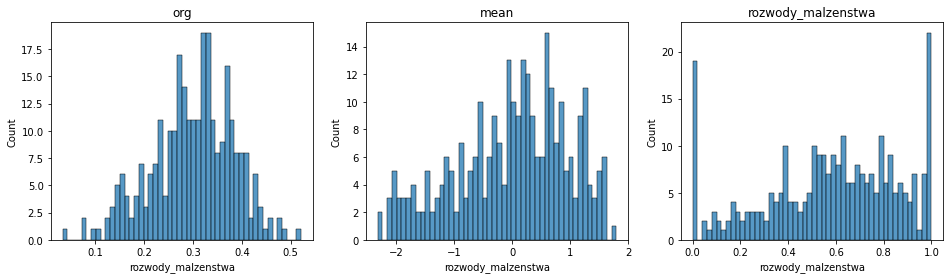

In [419]:
for c in high_corr_columns_final:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
    sn.histplot(pool_stat_df_org[c], bins=50, ax=ax[0])
    sn.histplot(pool_stat_df_m[c], bins=50, ax=ax[1])
    sn.histplot(pool_stat_df_mm[c], bins=50, ax=ax[2])
    ax[0].set_title('org')
    ax[1].set_title('mean')
    ax[2].set_title('minmax')
    plt.title(c)
    plt.show()

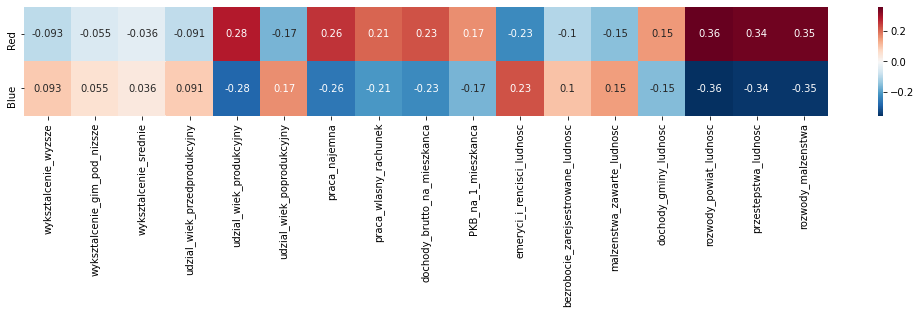

In [420]:
fig, ax = plt.subplots(figsize=(18,2))
sn.heatmap(pool_stat_df_m.corr().iloc[-2:,:-2], annot=True, cmap='RdBu_r', ax=ax)
plt.savefig('dane_pdf/dane_stat/corr_normalisation_per_year.pdf',  bbox_inches='tight')

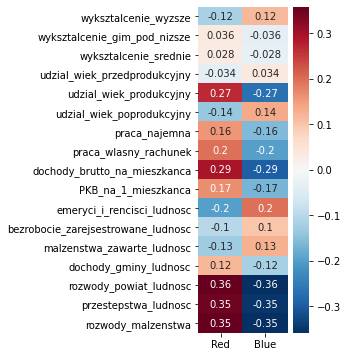

In [421]:
fig, ax = plt.subplots(figsize=(2,6))
sn.heatmap(pool_stat_df_mm.corr().iloc[:-2,-2:], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

In [422]:
potential_cols = pool_stat_df_mm.corr().iloc[:-2,-1].abs()
potential_cols = potential_cols[potential_cols>0.1]
high_cols = potential_cols.index.values.tolist()

potential_cols = pool_stat_df_m.corr().iloc[:-2,-1].abs()
potential_cols = potential_cols[potential_cols>0.1]
high_cols_m = potential_cols.index.values.tolist()

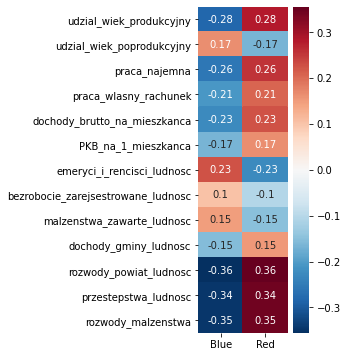

In [423]:
fig, ax = plt.subplots(figsize=(2,6))
sn.heatmap(pool_stat_df_m.corr().loc[high_cols_m,['Blue','Red']], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

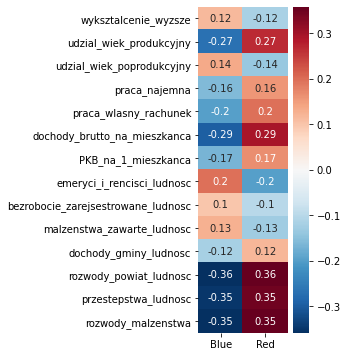

In [424]:
fig, ax = plt.subplots(figsize=(2,6))
sn.heatmap(pool_stat_df_mm.corr().loc[high_cols,['Blue','Red']], annot=True, cmap='RdBu_r', ax=ax)
plt.show()

In [425]:
#high_cols = high_cols_m
'''
[#'rozwody_powiat',
 'udzial_wiek_produkcyjny',
 'udzial_wiek_poprodukcyjny',
 'praca_najemna',
 'praca_wlasny_rachunek',
 'socjal',
 'dochody_brutto_na_mieszkanca',
 'PKB_na_1_mieszkanca',
 #'przestepstwa_ogolem',
 'przestepstwa_ludnosc',
 'emeryci_i_rencisci_ludnosc',
 'bezrobocie_zarejsestrowane_ludnosc',
 'malzenstwa_zawarte_ludnosc',
 'dochody_gminy_ludnosc',
 'rozwody_powiat_ludnosc',
 'rozwody_malzenstwa'
]
'''

"\n[#'rozwody_powiat',\n 'udzial_wiek_produkcyjny',\n 'udzial_wiek_poprodukcyjny',\n 'praca_najemna',\n 'praca_wlasny_rachunek',\n 'socjal',\n 'dochody_brutto_na_mieszkanca',\n 'PKB_na_1_mieszkanca',\n #'przestepstwa_ogolem',\n 'przestepstwa_ludnosc',\n 'emeryci_i_rencisci_ludnosc',\n 'bezrobocie_zarejsestrowane_ludnosc',\n 'malzenstwa_zawarte_ludnosc',\n 'dochody_gminy_ludnosc',\n 'rozwody_powiat_ludnosc',\n 'rozwody_malzenstwa'\n]\n"

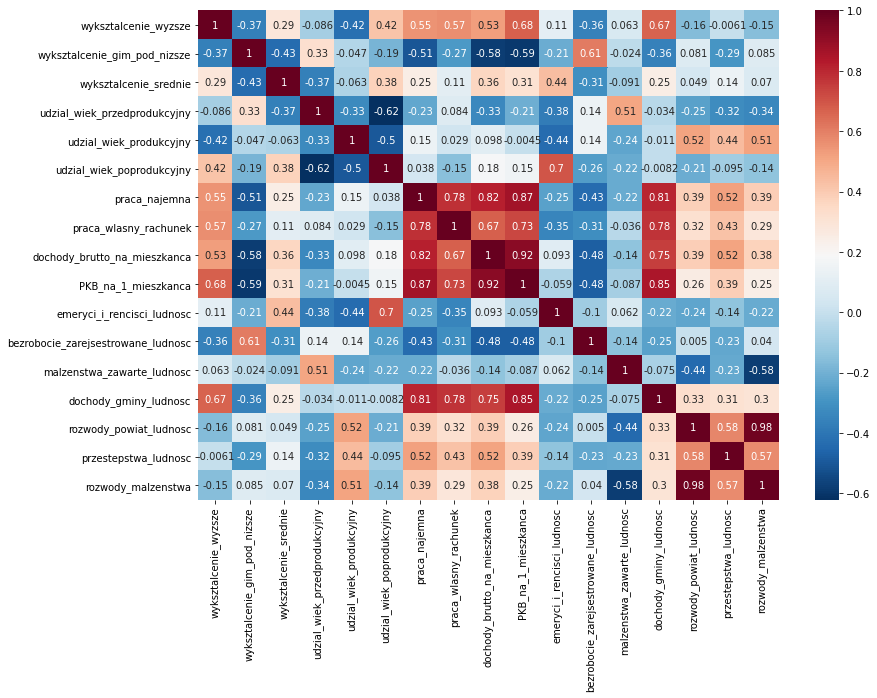

In [426]:
fig, ax = plt.subplots(figsize=(13,9))
sn.heatmap(pool_stat_df_mm.corr().loc[high_corr_columns_final,high_corr_columns_final], annot=True, cmap='RdBu_r')
#sn.heatmap(pool_stat_df_m.corr().loc[high_cols_m,high_cols_m], annot=True, cmap='RdBu_r')

plt.savefig('dane_pdf/dane_stat/corr_between.pdf',  bbox_inches='tight')

### Lasso

In [427]:
columns_to_use = high_corr_columns_final
#columns_to_use = columns_to_use[~columns_to_use.isin(['powierzchnnia_km2','ludnosc'])]
columns_to_use

Index(['wyksztalcenie_wyzsze', 'wyksztalcenie_gim_pod_nizsze',
       'wyksztalcenie_srednie', 'udzial_wiek_przedprodukcyjny',
       'udzial_wiek_produkcyjny', 'udzial_wiek_poprodukcyjny', 'praca_najemna',
       'praca_wlasny_rachunek', 'dochody_brutto_na_mieszkanca',
       'PKB_na_1_mieszkanca', 'emeryci_i_rencisci_ludnosc',
       'bezrobocie_zarejsestrowane_ludnosc', 'malzenstwa_zawarte_ludnosc',
       'dochody_gminy_ludnosc', 'rozwody_powiat_ludnosc',
       'przestepstwa_ludnosc', 'rozwody_malzenstwa'],
      dtype='object')

In [428]:
X = pool_stat_df_m.loc[:,columns_to_use].values
Y = pool_stat_df_m.iloc[:,-2].values

In [429]:
clf = Lasso(alpha=0.001)
clf.fit(X, Y)

rid = Ridge(alpha=0.1)
rid.fit(X, Y)

Ridge(alpha=0.1)

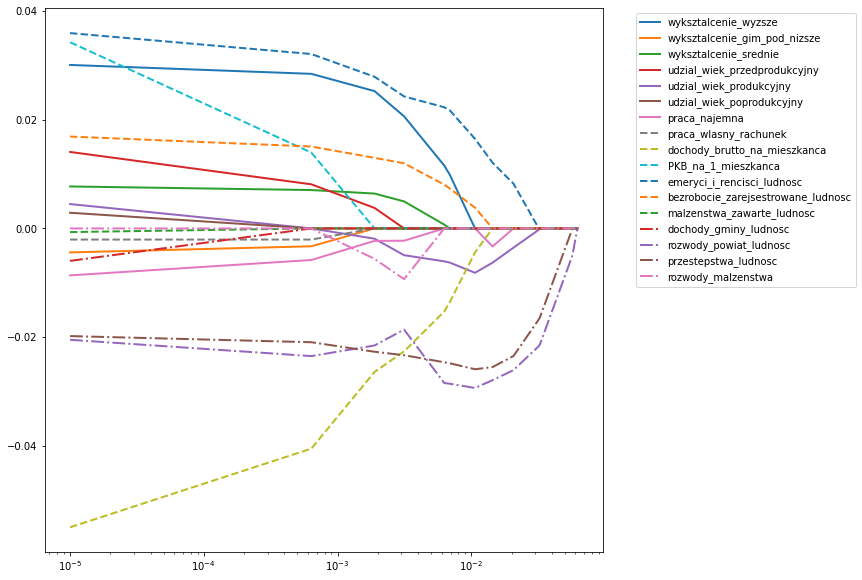

In [430]:
lb_lasso = 0.00001
ub_lasso = 0.062

laso_ls = np.linspace(lb_lasso, ub_lasso,100)

df_lasso_results = None

z = 0

for i, l in enumerate(laso_ls):
    clf = Lasso(alpha=l)
    clf.fit(X, Y)
    
    if z < (clf.coef_ == 0).sum():
        df_rand = pd.DataFrame({"names":columns_to_use, l:clf.coef_})

        if df_lasso_results is None:
            df_lasso_results = df_rand
        else:
            df_lasso_results = df_lasso_results.merge(df_rand, on='names', how='inner', suffixes=(str(i), str(i+1)))
        z = (clf.coef_ == 0).sum()
    #df_rand.sort_values("importance", ascending = False)[:10]
plt.figure(figsize=(10,10))
for i in range(df_lasso_results.shape[0]):
    l = '-'
    if(i>6):
        l = '--'
    if(i>12):
        l = 'dashdot'
   
    plt.plot(df_lasso_results.columns[1:], df_lasso_results.iloc[i,1:], ls=l, lw=2)

plt.xscale("log")
#plt.xticks([])
plt.legend(df_lasso_results['names'],  bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('dane_pdf/dane_stat/lasso_importances.pdf',  bbox_inches='tight')

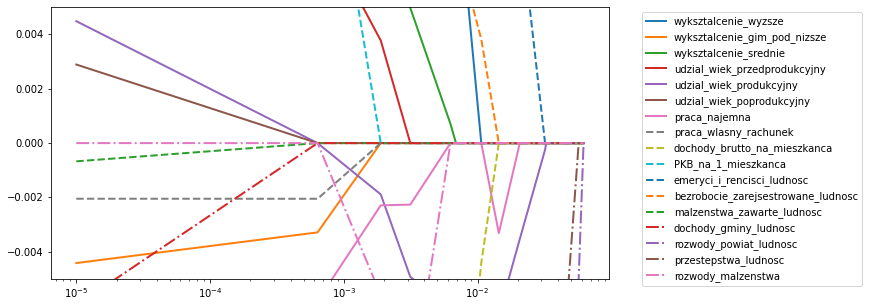

In [212]:
plt.figure(figsize=(10,5))
for i in range(df_lasso_results.shape[0]):
    l = '-'
    if(i>6):
        l = '--'
    if(i>12):
        l = 'dashdot'
   
    plt.plot(df_lasso_results.columns[1:], df_lasso_results.iloc[i,1:], ls=l, lw=2)

plt.xscale("log")
plt.ylim([-0.005,0.005])
#plt.xticks([])
plt.legend(df_lasso_results['names'],  bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('dane_pdf/dane_stat/lasso_importances_zoom.pdf',  bbox_inches='tight')

In [213]:
df_lasso_results

,names,1e-05,0.0006361616161616162,0.0018884848484848485,0.003140808080808081,0.006271616161616161,0.006897777777777777,0.010654747474747475,0.014411717171717171,0.020673333333333332,0.03194424242424243,0.032570404040404045,0.056990707070707074,0.062
0,wyksztalcenie_wyzsze,0.030085,0.028449,0.025271,0.020631,0.011577,0.009879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,wyksztalcenie_gim_pod_nizsze,-0.004413,-0.003285,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,wyksztalcenie_srednie,0.007725,0.007065,0.006417,0.004973,0.000703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,udzial_wiek_przedprodukcyjny,0.014074,0.008120,0.003774,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
4,udzial_wiek_produkcyjny,0.004485,-0.000000,-0.001888,-0.004923,-0.006055,-0.006284,-0.008159,-0.006294,-0.003532,-0.000244,-0.000000,-0.000000,-0.0
5,udzial_wiek_poprodukcyjny,0.002890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,praca_najemna,-0.008637,-0.005808,-0.002291,-0.002263,-0.000000,-0.000000,-0.000000,-0.003312,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
7,praca_wlasny_rachunek,-0.002046,-0.002048,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
8,dochody_brutto_na_mieszkanca,-0.054992,-0.040521,-0.026408,-0.022630,-0.015288,-0.013561,-0.004405,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0
9,PKB_na_1_mieszkanca,0.034265,0.013961,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.0


In [214]:
df_lasso = pd.DataFrame({"weights abs":np.abs(clf.coef_), 
                         "weights":clf.coef_,
                         "names":columns_to_use})
df_lasso.sort_values("weights abs", ascending = False)[:10]

,weights abs,weights,names
0,0.0,0.0,wyksztalcenie_wyzsze
9,0.0,-0.0,PKB_na_1_mieszkanca
15,0.0,-0.0,przestepstwa_ludnosc
14,0.0,-0.0,rozwody_powiat_ludnosc
13,0.0,-0.0,dochody_gminy_ludnosc
12,0.0,0.0,malzenstwa_zawarte_ludnosc
11,0.0,0.0,bezrobocie_zarejsestrowane_ludnosc
10,0.0,0.0,emeryci_i_rencisci_ludnosc
8,0.0,-0.0,dochody_brutto_na_mieszkanca
1,0.0,0.0,wyksztalcenie_gim_pod_nizsze


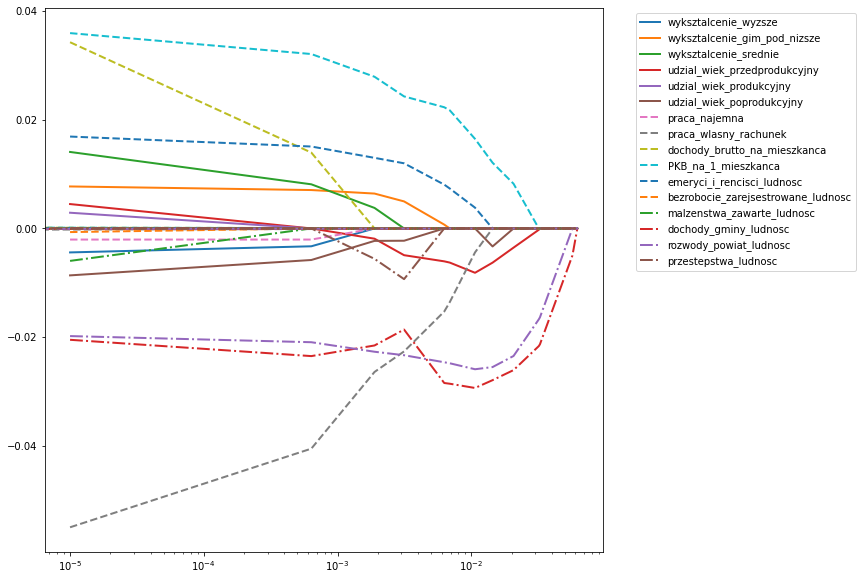

In [215]:
lb_ridge = 0.00001
ub_ridge = 0

ridge_ls = np.linspace(lb_ridge, ub_ridge,100)

df_ridge_results = None

for i, l in enumerate(ridge_ls):
    clf = Ridge(alpha=l)
    clf.fit(X, Y)
    

    df_rand = pd.DataFrame({"names":columns_to_use, l:clf.coef_})

    if df_ridge_results is None:
        df_ridge_results = df_rand
    else:
        df_ridge_results = df_lasso_results.merge(df_rand, on='names', how='inner', suffixes=(str(i), str(i+1)))
    #df_rand.sort_values("importance", ascending = False)[:10]
plt.figure(figsize=(10,10))
for i in range(1,df_ridge_results.shape[0]):
    l = '-'
    if(i>6):
        l = '--'
    if(i>12):
        l = 'dashdot'
   
    plt.plot(df_ridge_results.columns[1:], df_ridge_results.iloc[i,1:], ls=l, lw=2)

plt.xscale("log")
#plt.xticks([])
plt.legend(df_lasso_results['names'],  bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('dane_pdf/dane_stat/ridge_importances.pdf',  bbox_inches='tight')

In [216]:
df_ridge = pd.DataFrame({"weights abs":np.abs(rid.coef_), 
                         "weights":rid.coef_,
                         "names":columns_to_use})
df_ridge.sort_values("weights abs", ascending = False)[:10]

,weights abs,weights,names
8,0.054355,-0.054355,dochody_brutto_na_mieszkanca
10,0.035598,0.035598,emeryci_i_rencisci_ludnosc
9,0.033792,0.033792,PKB_na_1_mieszkanca
0,0.029993,0.029993,wyksztalcenie_wyzsze
14,0.021389,-0.021389,rozwody_powiat_ludnosc
15,0.019878,-0.019878,przestepstwa_ludnosc
11,0.017150,0.017150,bezrobocie_zarejsestrowane_ludnosc
3,0.015744,0.015744,udzial_wiek_przedprodukcyjny
6,0.008844,-0.008844,praca_najemna
2,0.007752,0.007752,wyksztalcenie_srednie


### Random Forest

In [217]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X, Y)

df_rand = pd.DataFrame({"importance":regr.feature_importances_, "names":columns_to_use})

df_rand.sort_values("importance", ascending = False)#[:10]

,importance,names
6,0.305737,praca_najemna
4,0.116922,udzial_wiek_produkcyjny
16,0.107075,rozwody_malzenstwa
15,0.068461,przestepstwa_ludnosc
8,0.059886,dochody_brutto_na_mieszkanca
14,0.059379,rozwody_powiat_ludnosc
13,0.057082,dochody_gminy_ludnosc
9,0.051681,PKB_na_1_mieszkanca
7,0.044387,praca_wlasny_rachunek
0,0.028586,wyksztalcenie_wyzsze


In [218]:
df_rf_results = None
    
for i in range(100):
    regr = RandomForestRegressor(max_depth=2)
    regr.fit(X, Y)

    df_rand = pd.DataFrame({"names":columns_to_use, "importance":regr.feature_importances_ })
    
    if df_rf_results is None:
        df_rf_results = df_rand
    else:
        df_rf_results = df_rf_results.merge(df_rand, on='names', how='inner', suffixes=(str(i), str(i+1)))

    #df_rand.sort_values("importance", ascending = False)[:10]

In [219]:
df_rf_results['mean'] = df_rf_results.iloc[:,1:].mean(1)
df_rf_results['std'] = df_rf_results.iloc[:,1:-1].std(1)
df_rf_results[['names','mean','std']].sort_values("mean", ascending = False)#[:10]

,names,mean,std
6,praca_najemna,0.352109,0.028388
4,udzial_wiek_produkcyjny,0.108291,0.012596
16,rozwody_malzenstwa,0.089372,0.020795
14,rozwody_powiat_ludnosc,0.076191,0.019690
15,przestepstwa_ludnosc,0.074866,0.016335
13,dochody_gminy_ludnosc,0.057965,0.008935
9,PKB_na_1_mieszkanca,0.043356,0.012084
8,dochody_brutto_na_mieszkanca,0.042690,0.014794
0,wyksztalcenie_wyzsze,0.031602,0.007820
5,udzial_wiek_poprodukcyjny,0.028153,0.008695


### PCA

In [220]:
pca = PCA(n_components=10)
x_new = pca.fit_transform(X)

In [221]:
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_[:3]))

[0.3628665  0.20948023 0.15270548 0.07771178 0.04495931 0.03981945
 0.0318515  0.02402028 0.01916851 0.01020277]
0.7250521969614295


In [222]:
for x in range(data_reshaped.shape[1]):
    colors.loc[colors.wojewodztwo==stat_list_org[0].index[x],:].values[0][1]

In [223]:
columns_to_use

Index(['wyksztalcenie_wyzsze', 'wyksztalcenie_gim_pod_nizsze',
       'wyksztalcenie_srednie', 'udzial_wiek_przedprodukcyjny',
       'udzial_wiek_produkcyjny', 'udzial_wiek_poprodukcyjny', 'praca_najemna',
       'praca_wlasny_rachunek', 'dochody_brutto_na_mieszkanca',
       'PKB_na_1_mieszkanca', 'emeryci_i_rencisci_ludnosc',
       'bezrobocie_zarejsestrowane_ludnosc', 'malzenstwa_zawarte_ludnosc',
       'dochody_gminy_ludnosc', 'rozwody_powiat_ludnosc',
       'przestepstwa_ludnosc', 'rozwody_malzenstwa'],
      dtype='object')

In [224]:
color_list = []
for w in pool_stat_df_m['index']:
    if w == 'MAŁOPOLSKIE': color_list.append('C0')
    elif w == 'ŚLĄSKIE': color_list.append('C1')
    elif w == 'LUBUSKIE': color_list.append('C2')
    elif w == 'WIELKOPOLSKIE': color_list.append('C3')
    elif w == 'ZACHODNIOPOMORSKIE': color_list.append('C4')
    elif w == 'DOLNOŚLĄSKIE': color_list.append('C5')
    elif w == 'OPOLSKIE': color_list.append('C6')
    elif w == 'KUJAWSKO-POMORSKIE': color_list.append('C7')
    elif w == 'POMORSKIE': color_list.append('C8')
    elif w == 'WARMIŃSKO-MAZURSKIE': color_list.append('C9')
    elif w == 'ŁÓDZKIE': color_list.append('C10')
    elif w == 'ŚWIĘTOKRZYSKIE': color_list.append('C11')
    elif w == 'LUBELSKIE': color_list.append('C12')
    elif w == 'PODKARPACKIE': color_list.append('C13')
    elif w == 'PODLASKIE': color_list.append('C14')
    elif w == 'MAZOWIECKIE': color_list.append('C15')

color_list = []
for w in pool_stat_df_m['index']:
    color_list.append(colors.loc[colors.wojewodztwo==w,:].values[0][1])

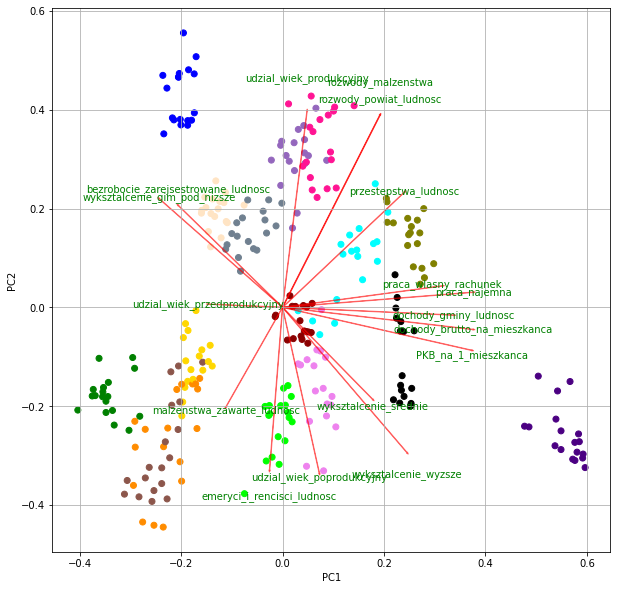

In [225]:
cols_plotting = columns_to_use
plt.figure(figsize=(10,10))

def myplot(score,coeff,width=0.001,c_arr=['r'],scale=1):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = color_list)
    
    c_txt = ['g']*n
    if len(c_arr) == 1:
        c_arr = c_arr*n
    else:
        c_txt = c_arr
        
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = c_arr[i],alpha = 0.5,width=width)
        
        plt.text(coeff[i,0]* scale, coeff[i,1] * (scale + np.random.random()*0.2) , cols_plotting[i], color = c_txt[i], ha = 'center', va = 'center')

#plt.xlim(-1,1)
#plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.savefig('dane_pdf/dane_stat/PCA12.pdf',  bbox_inches='tight')

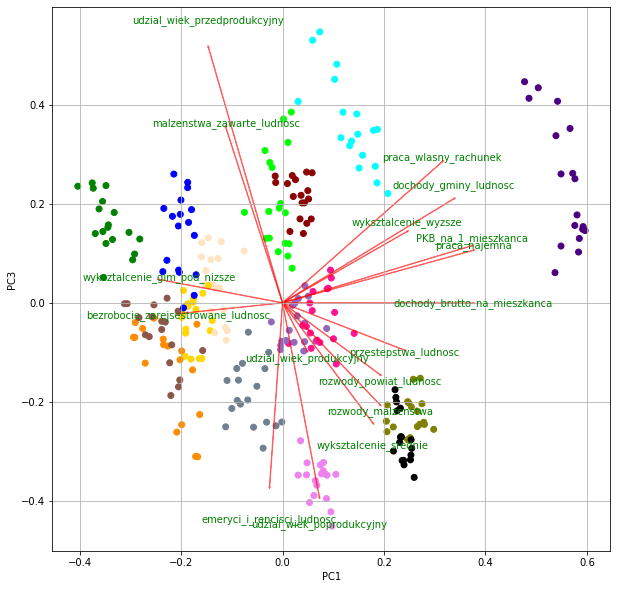

In [226]:
plt.figure(figsize=(10,10))
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(3))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,[0,2]],np.transpose(pca.components_[[0,2], :]))
plt.savefig('dane_pdf/dane_stat/PCA13.pdf',  bbox_inches='tight')

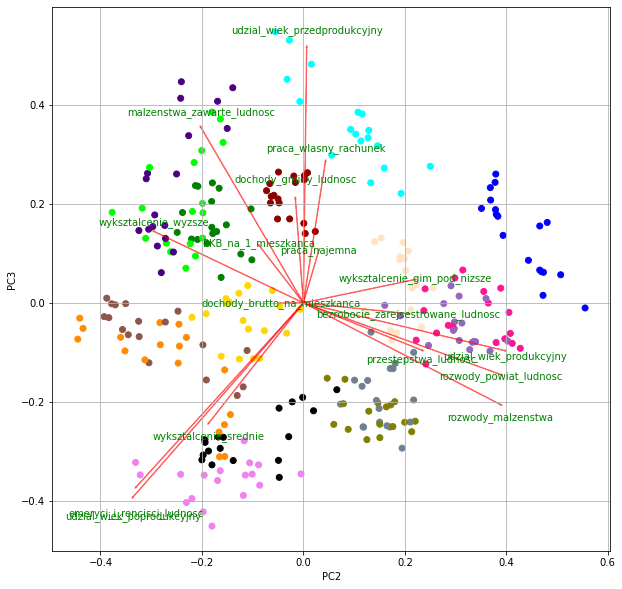

In [227]:
plt.figure(figsize=(10,10))
plt.xlabel("PC{}".format(2))
plt.ylabel("PC{}".format(3))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,[1,2]],np.transpose(pca.components_[[1,2], :]))
plt.savefig('dane_pdf/dane_stat/PCA23.pdf',  bbox_inches='tight')

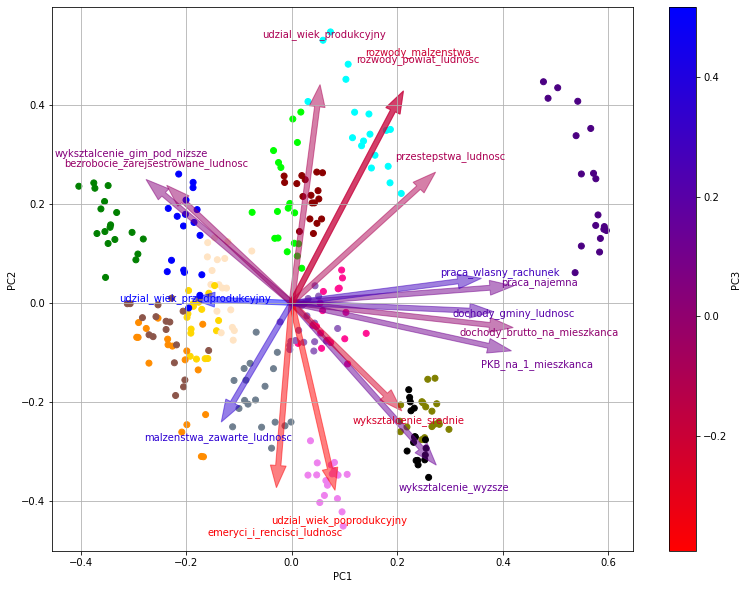

In [228]:
import matplotlib.colors as mcol
import matplotlib.cm as cm

z_axis = pca.components_[2, :]

cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])
cnorm = mcol.Normalize(vmin=np.min(z_axis),vmax=np.max(z_axis))

cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)
cpick.set_array([])

plt.figure(figsize=(13,10))
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x_new[:,[0,2]],
       np.transpose(pca.components_[[0,1], :]),
       width=0.01,
       c_arr=cpick.to_rgba(pca.components_[2, :]), 
       scale = 1.25)
plt.colorbar(cpick,label="PC3")
plt.savefig('dane_pdf/dane_stat/PCA12_colors_4th.pdf',  bbox_inches='tight')

In [229]:
pca.components_.shape

(10, 17)

<IPython.core.display.Javascript object>


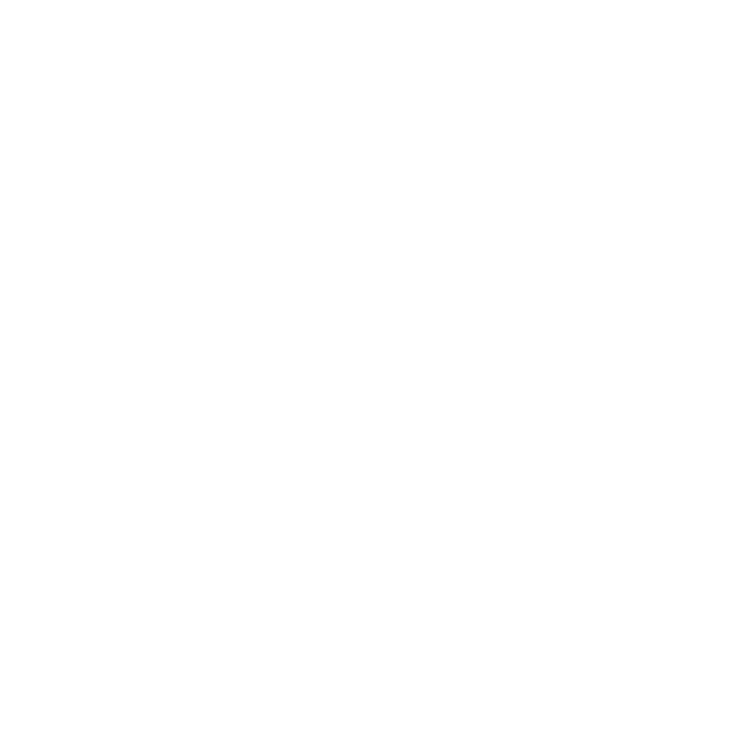

<IPython.core.display.Javascript object>


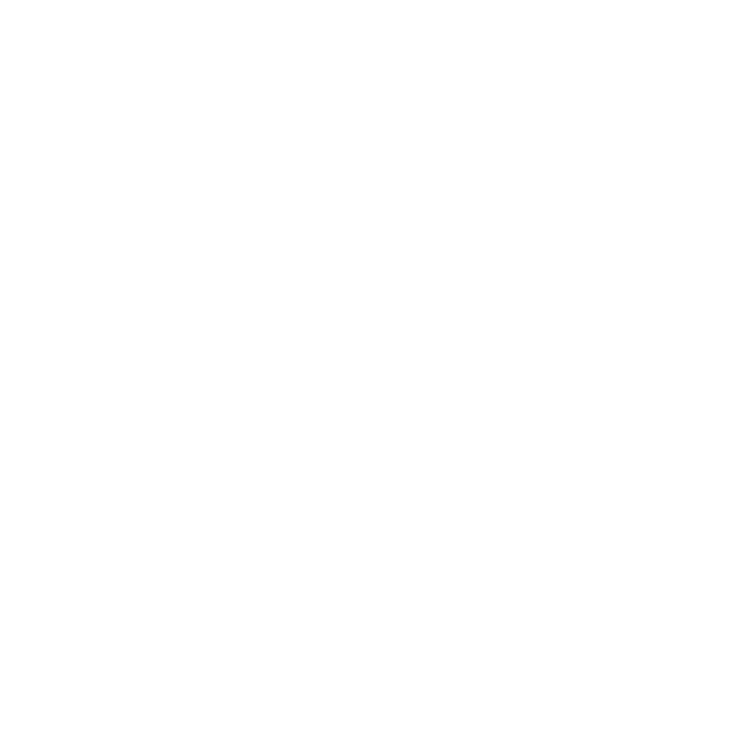

In [230]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Xax = x_new[:,0]
Yax = x_new[:,1]
Zax = x_new[:,2]

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Xax, Yax, Zax)

#coeff = pca.components_[[0,1,2], :]
coeff = np.transpose(pca.components_[0:3, :])
n = coeff.shape[0]
    
for i in range(n):
    #ax.plot([mean_x,v[0]], [mean_y,v[1]], [mean_z,v[2]], color='red', alpha=0.8, lw=3)
    #I will replace this line with:
    a = Arrow3D([0, coeff[i,0]*15], 
                [0, coeff[i,1]*15], 
                [0, coeff[i,2]*15], mutation_scale=20, 
                lw=1, arrowstyle="-|>", color="r")
    ax.add_artist(a)

for i in range(n):
    ax.text(coeff[i,0]* 15, 
            coeff[i,1] * 15, 
            coeff[i,2] * 15, cols_plotting[i], (1,1,0), fontsize=7)


# for loop ends
ax.set_xlabel("PC1", fontsize=14)
ax.set_ylabel("PC2", fontsize=14)
ax.set_zlabel("PC3", fontsize=14)

plt.show()

## Final variables selection

In [235]:
columns_to_use

Index(['wyksztalcenie_wyzsze', 'wyksztalcenie_gim_pod_nizsze',
       'wyksztalcenie_srednie', 'udzial_wiek_przedprodukcyjny',
       'udzial_wiek_produkcyjny', 'udzial_wiek_poprodukcyjny', 'praca_najemna',
       'praca_wlasny_rachunek', 'dochody_brutto_na_mieszkanca',
       'PKB_na_1_mieszkanca', 'emeryci_i_rencisci_ludnosc',
       'bezrobocie_zarejsestrowane_ludnosc', 'malzenstwa_zawarte_ludnosc',
       'dochody_gminy_ludnosc', 'rozwody_powiat_ludnosc',
       'przestepstwa_ludnosc', 'rozwody_malzenstwa'],
      dtype='object')

In [440]:
high_cols = [
    'rozwody_powiat_ludnosc',
    'praca_najemna',
    'dochody_brutto_na_mieszkanca',
    'emeryci_i_rencisci_ludnosc',
    'udzial_wiek_przedprodukcyjny',
    'bezrobocie_zarejsestrowane_ludnosc',
    'wyksztalcenie_wyzsze',
    'przestepstwa_ludnosc'
 #'dochody_gminy_ludnosc',
 #'rozwody_powiat_ludnosc'
 #'rozwody_malzenstwa'
]

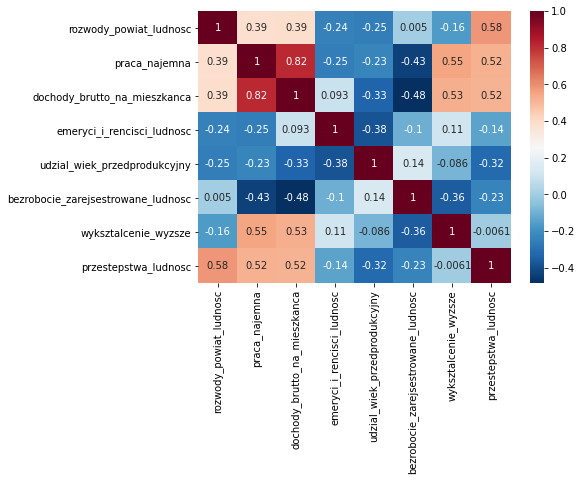

In [441]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,5))
sn.heatmap(pool_stat_df_mm.corr().loc[high_cols,high_cols], annot=True, cmap='RdBu_r')
plt.savefig('dane_pdf/dane_stat/corr_between_choosen.pdf',  bbox_inches='tight')

In [442]:
# cclumns_to_use
stat_list = [st.loc[:,high_cols] for st in stat_list]

# Model

## Prepare input (X) (parameters which we will multiply)
Input - wagi, <br>
na outpucie mnożenie wag razy wartości i na tej podstawie ocena.
- poprzednie wybory (par in reg/ reg in par)
- wpływ sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

In [443]:
X = []
# iterate over years [from 2002 - 2019]
for y in range(len(stat_list)):
    # iterate over districts
    tmp_x = []
    st_data = stat_list[y]
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        neigh = neighbours[lo.name.lower()]
        avg_n = [pool_d[y].loc[n.upper()][0]/pool_d[y].loc[n.upper()].sum() for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        tmp_y = st_data.iloc[d,:].values.tolist()
        tmp_y.append(lo[0]/lo.sum())
        tmp_y.append(avg_n)
                
        tmp_x.append(tmp_y)
    X.append(tmp_x)

In [444]:
X = np.array(X)
X.shape

(18, 16, 10)

## Prepare Y

In [445]:
Y = []
for y in range(1,pool_data_middle.shape[0]):
    # iterate over districts
    tmp_y = []
    for d in range(vote_list[0].shape[0]):
        # 1. last election: Blue, Red, Gray
        #    Blue/All
        # 2. neighbours
        # 3. one (1)
        lo = pool_d[y].iloc[d,:]
        tmp_y.append([lo[0]/lo.sum()])
    Y.append(tmp_y)

In [446]:
Y = np.array(Y)
Y.shape

(18, 16, 1)

## Parameters to be estimated
- waga poprzednie wybory
- waga wpływu sąsiadów (avg over nighbours/ weighted avg)
- pole zewnętrzne 

## Process
- input,
- warstwy,
- output (parametry lub wagi),
- output\*parameters (the real output - wynik wyborów)

**OR**
- input (parameters),
- simple network to get the weight = parameters to multiply,
- output (next election)

## Training phase (looking for parameters)

Functions for models

In [447]:
X.shape

(18, 16, 10)

### Models with percentage of Blue support per district

In [449]:
def model_percent(a,x):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    OUTPUT:
    y - predicted value in (0,1)
    '''
    #d0 = x.shape[0] if (len(x.shape) == 3) else 1
    #d1 = x.shape[-1] 
    
    #a = np.repeat(a, d0, 0)
    #x = x.reshape(-1, d1) 
    
    #return 1 / (1+np.exp(-np.sum(x.dot(a.T))))
    y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))
    return y

def grad_percent(a,x,y):
    '''
    INPUT:
    a - vector of weights 16x14
    x - vector of input data 18x16x14
    '''
    #return a * np.exp(-x.T.dot(a)) / (1+np.exp(-x.T.dot(a)))**2
    #return a*np.exp(-np.sum(x*a,1,keepdims=True)) / (1+np.exp(-np.sum(x*a,1,keepdims=True)))**2
    d0 = x.shape[0] if (len(x.shape) == 3) else 1
    d1 = x.shape[-1] 
    
    a = np.repeat(a, d0, 0)
    x = x.reshape(-1, d1)
    y = y.reshape(-1, 1)
    y1 = -(2 * 
          ( y - 1/(1+np.exp(-np.sum(x*a,1,keepdims=True))) ) * 
          1/(1+np.exp(-np.sum(x*a,1,keepdims=True)))**2 *
          np.exp(-np.sum(x*a,1,keepdims=True)) *
          x)
    return y1

### Setup for testing model

In [450]:
neigh_ndx = []
for d in range(X.shape[1]):
    # 1. last election: Blue, Red, Gray
    #    Blue/All
    # 2. neighbours
    # 3. one (1)
    lo = par_in_reg_list[0].iloc[d,:]        
    neigh = neighbours[lo.name.lower()]
    indexs = par_in_reg_list[0].index.values
    neigh_ndx.append(np.searchsorted(indexs, np.char.upper(neigh)))

In [451]:
st_data.shape

(16, 8)

In [452]:
def prepare_input(y, st_data):
    tmp_x = np.zeros((y.shape[0],st_data.shape[-1]+2))
    for d in range(y.shape[0]):
        neigh = neigh_ndx[d]
        avg_n = [y[n,0]/np.sum(y[neigh,0]) for n in neigh]
        avg_n = sum(avg_n)/len(neigh)
        
        tmp_y = st_data.iloc[d,:].values.tolist()
        tmp_y.append(y[d,0])
        tmp_y.append(avg_n)
        
        tmp_x[d] = np.array(tmp_y)
    return(tmp_x)

In [453]:
def model(a,x,Y,st_list):
    y = Y[0]
    loss = []
    out = np.zeros(Y.shape)
    out[0] = y
    for year in range(1,X.shape[0]):
        st_data = stat_list[year-1]
        xi = prepare_input(y,st_list[year-1])
        y = model_percent(a,xi)
        loss.append(np.sum((y - Y[year])**2))
        #print(y.shape,'loss:', np.sum((y - Y[year])**2))
        out[year] = y
    return loss, out

In [454]:
loss_p = np.inf
loss_v = np.inf

a_avg = np.random.rand(X.shape[1],X.shape[2])
a_all = a_avg
#av = np.random.rand(X.shape[1],X.shape[2])

step = 0.01
beta = 0.1
a_avg.shape

(16, 10)

## Use output -> next input (grad each step)

loss: 0.4992461228660229
loss: 0.1633779399423418
loss: 0.13522906619532768
loss: 0.1221703689713477
loss: 0.11580777130885063
loss: 0.11318640302413414
loss: 0.11253896755153257
loss: 0.11236932467071534
loss: 0.11206863112757771
loss: 0.1116451966919623


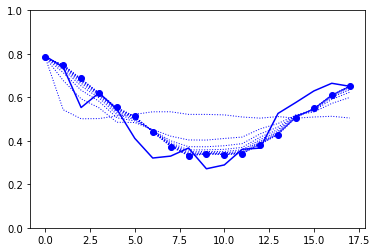

In [455]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 0.1 

loss_arr = np.zeros((10**3,))

loss_prev = np.inf

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)
    
    loss_arr[epoch] = loss_p
    #if loss_p < loss_prev:
    #    step = step*0.95
    #else:
    #    step = step*1.05
    
    #loss_prev = loss_p
            
    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        print('loss:', np.mean(l))
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

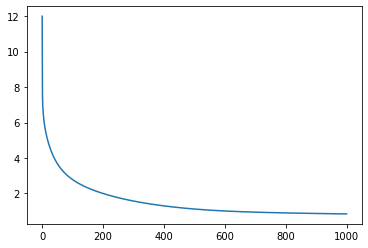

In [458]:
plt.plot(loss_arr)
plt.show()

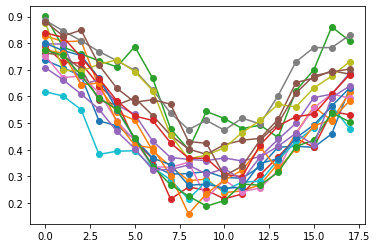

In [459]:
plt.plot(o.reshape(-1,16),'o-')
plt.show()

### Compare of parameters per each district

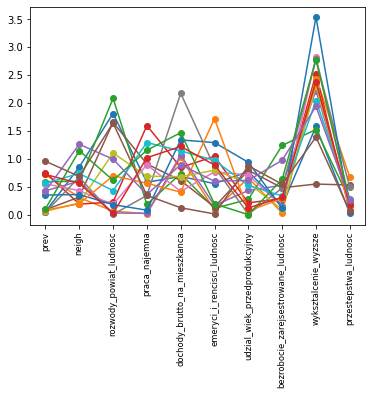

In [460]:
plt.plot(np.abs(a_step.T), 'o-')
plt.xticks(range(a_step.shape[1]), ['prev','neigh']+high_cols, size='small',rotation=90)
plt.show()

In [469]:
np.abs(a_step).shape

(16, 10)

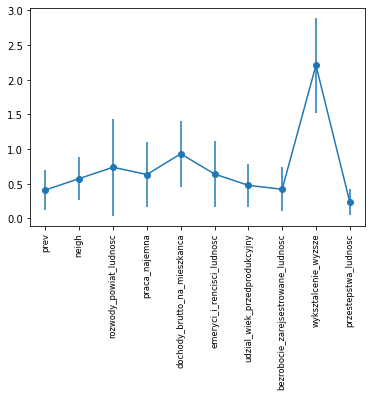

In [470]:
plt.plot(np.abs(a_step).mean(0), 'o-')
plt.errorbar(np.arange(a_step.shape[1]), np.abs(a_step).mean(0), np.abs(a_step).std(0), linestyle='None', marker='', ecolor='tab:blue')
e = np.abs(a_step).std(0)
plt.xticks(range(a_step.shape[1]), ['prev','neigh']+high_cols, size='small',rotation=90)
plt.show()

<ipython-input-102-8ddb180abbf0>:16: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-102-8ddb180abbf0>:16: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-102-8ddb180abbf0>:16: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-102-8ddb180abbf0>:16: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-102-8ddb180abbf0>:16: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-102-8ddb180abbf0>:16: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


<ipython-input-102-8ddb180abbf0>:16: RuntimeWarning: overflow encountered in exp
  y = 1 / (1+np.exp(-np.sum(x*a, 1, keepdims=True)))


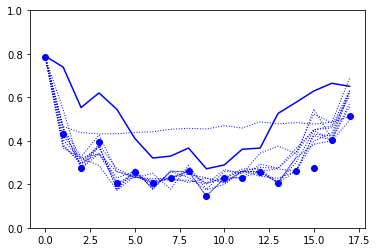

In [115]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 1

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

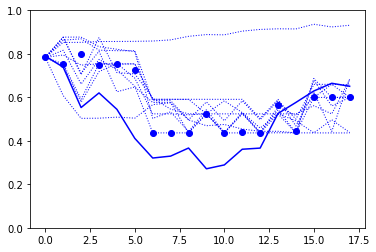

In [116]:
a_step = np.random.rand(X.shape[1],X.shape[2]) - 0.5
step = 10

for epoch in range(10**3):
    print(epoch,end='\r')
    loss_p = 0
    y = Y[0]
    for i in range(X.shape[0]):
        xi = prepare_input(y,stat_list[i])
        y = model_percent(a_step,xi)

        grad = grad_percent(a_step,xi,Y[i])#.reshape(18,16,3)
        #grad = np.sum(grad, axis=0)
        a_step = a_step - step*grad

        loss_p += np.sum((model_percent(a_step,xi) - Y[i].reshape(-1,1))**2)

    if epoch%100==0: 
        l, o = model(a_step,X,Y,stat_list)
        plt.plot(np.average(o,1, voter_w[1]),'b:', linewidth=1)

l, o = model(a_step,X,Y,stat_list)
plt.plot(np.average(o,1, voter_w[1]),'bo', linewidth=1)
    
plt.plot(pool_data_middle['Blue'].values[1:],'b')    
plt.ylim(0,1)
plt.show()

## All at once + evolution strategies (TO DO)

# https://towardsdatascience.com/introduction-to-evolution-strategy-1b78b9d48385
for epoch in range(10**3):
    grad = grad_percent(a_avg,X).reshape(18,16,3)
    grad = np.sum(grad, axis=0)
    a_avg = a_avg - step*grad
    
    #if epoch%50==0: 
    #    if np.sum((model_percent(ap,X) - Y.reshape(-1,1))**2) < loss_p: step *= (1+beta)
    #    else: step /= (1-beta)

    loss_p = np.sum((model_percent(a_avg,X) - Y.reshape(-1,1))**2)

    if epoch%100==0: 
        print('loss sum:',loss_p)
a_avg.shape

In [ ]:
l_avg, o = model(a_avg,X,Y)
l_all, o = model(a_all,X,Y)
plt.plot(l_avg,'bo')
plt.plot(l_all,'ro')
plt.plot()

## Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM)
https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/ <br>
http://proceedings.mlr.press/v57/zhao16.pdf <br>
https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816 <br>
https://developer.apple.com/documentation/coreml/core_ml_api/making_predictions_with_a_sequence_of_inputs <br>
https://www.youtube.com/watch?v=WCUNPb-5EYI

In [ ]:
(a_avg-a_all).max()